## Importamos librerías

In [1]:
import pickle
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")


from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import random
MYSEED=42
random.seed(MYSEED)


In [2]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.4
XGBoost version 1.7.3


In [3]:
def decompose_ts(ts_to_decompose, period, title):
    '''
    Uses seasonal_decompose from statsmodels to decompose a ts.
    Plots the results on 4 differents plots.
    '''

    # decompose the series using stats module
    # results in this case is a special class 
    # whose attributes we can acess
    result = seasonal_decompose(ts_to_decompose, period = period)

    # ----------------------------------------------------------------------------------------------------
    # instanciate the figure
    # make the subplots share teh x axis
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (10, 6))

    # ----------------------------------------------------------------------------------------------------
    # plot the data

    # plot the original data
    result.observed.plot(ax = axes[0], legend = False)
    axes[0].set_ylabel('Observed')
    axes[0].set_title(title)

    # plot the trend
    result.trend.plot(ax = axes[1], legend = False)
    axes[1].set_ylabel('Trend')

    # plot the seasonal part
    result.seasonal.plot(ax = axes[2], legend = False)
    axes[2].set_ylabel('Seasonal')

    # plot the residual
    result.resid.plot(ax = axes[3], legend = False)
    axes[3].set_ylabel('Residual');

## Importamos el dataset

In [4]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "../Downloads") 
TRAIN_PKL_PATH = os.path.join(DATA_PATH, "df_final20230317.pkl")

In [5]:
df = pd.read_pickle(f'{DATA_PATH}/df_final20230317.pkl')

In [6]:
df.head()

yearweek                      id              item    category  \
0    201105  ACCESORIES_1_001_NYC_1  ACCESORIES_1_001  ACCESORIES   
1    201105  ACCESORIES_1_002_NYC_1  ACCESORIES_1_002  ACCESORIES   
2    201105  ACCESORIES_1_003_NYC_1  ACCESORIES_1_003  ACCESORIES   
3    201105  ACCESORIES_1_004_NYC_1  ACCESORIES_1_004  ACCESORIES   
4    201105  ACCESORIES_1_005_NYC_1  ACCESORIES_1_005  ACCESORIES   

               store store_code    region  weekly_sales  estacion  week_event  \
0  Greenwich_Village      NYC_1  New York             0  invierno           0   
1  Greenwich_Village      NYC_1  New York             0  invierno           0   
2  Greenwich_Village      NYC_1  New York             0  invierno           0   
3  Greenwich_Village      NYC_1  New York             0  invierno           0   
4  Greenwich_Village      NYC_1  New York             0  invierno           0   

   ...  San_Patricio  San_Valentin  Superbowl  Thanksgiving  Amazon_prime_day  \
0  ...             0             0          0             0                 0   
1  ...             0             0          0             0                 0   
2  ...             0             0          0             0                 0   
3  ...             0             0          0             0                 0   
4  ...             0             0          0             0                 0   

   dia_de_la_indep  dia_madre  dia_padre  sell_price  revenue  
0                0          0          0       12.74      0.0  
1                0          0          0        5.28      0.0  
2                0          0          0        3.95      0.0  
3                0          0          0        5.77      0.0  
4                0          0          0        3.96      0.0  

[5 rows x 22 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8323770 entries, 0 to 8323769
Data columns (total 22 columns):
 #   Column            Dtype   
---  ------            -----   
 0   yearweek          int32   
 1   id                object  
 2   item              category
 3   category          category
 4   store             category
 5   store_code        category
 6   region            category
 7   weekly_sales      int32   
 8   estacion          object  
 9   week_event        int64   
 10  Predidents_day    uint8   
 11  Ramadan_starts    uint8   
 12  San_Patricio      uint8   
 13  San_Valentin      uint8   
 14  Superbowl         uint8   
 15  Thanksgiving      uint8   
 16  Amazon_prime_day  uint8   
 17  dia_de_la_indep   uint8   
 18  dia_madre         uint8   
 19  dia_padre         uint8   
 20  sell_price        float64 
 21  revenue           float64 
dtypes: category(5), float64(2), int32(2), int64(1), object(2), uint8(10)
memory usage: 571.6+ MB


Tenemos un total de 30490 series temporales en el DS:

In [8]:
df['id'].nunique()

30490

Escogemos y alistamos los 100 productos más vendido para hacer una previsión de ventas sobre estos.

In [9]:
df['yearweek']=df['yearweek'].astype('str')

In [10]:
import datetime
df['yearweek'] = df['yearweek'].apply(lambda x: datetime.datetime.strptime(x + '0', "%Y%W%w"))

Wall time: 1min 4s


<AxesSubplot:xlabel='yearweek', ylabel='weekly_sales'>

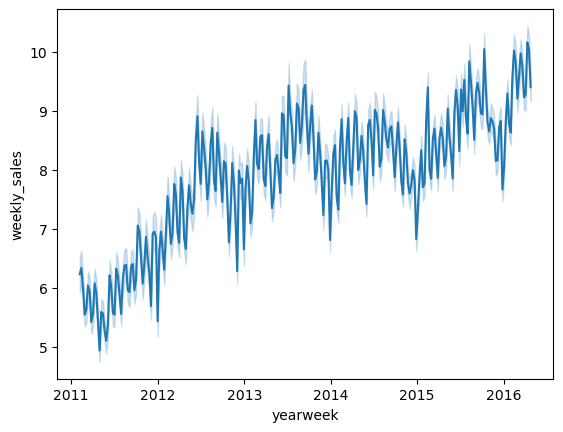

In [11]:
%%time
import seaborn as sns

sns.lineplot(data=df,
             x='yearweek',
             y='weekly_sales')

In [12]:
df.sample(5)

yearweek                       id               item     category  \
8225919 2016-04-03  SUPERMARKET_3_542_PHI_1  SUPERMARKET_3_542  SUPERMARKET   
5079178 2014-04-13  SUPERMARKET_3_369_BOS_2  SUPERMARKET_3_369  SUPERMARKET   
4529840 2013-12-08  SUPERMARKET_2_249_BOS_2  SUPERMARKET_2_249  SUPERMARKET   
5296274 2014-06-01   ACCESORIES_1_166_PHI_1   ACCESORIES_1_166   ACCESORIES   
8243949 2016-04-10  SUPERMARKET_3_278_NYC_4  SUPERMARKET_3_278  SUPERMARKET   

                   store store_code        region  weekly_sales   estacion  \
8225919  Midtown_Village      PHI_1  Philadelphia             8   invierno   
5079178          Roxbury      BOS_2        Boston             8  primavera   
4529840          Roxbury      BOS_2        Boston             0      otoño   
5296274  Midtown_Village      PHI_1  Philadelphia             0  primavera   
8243949         Brooklyn      NYC_4      New York             6  primavera   

         week_event  ...  San_Patricio  San_Valentin  Superbowl  Thanksgiving  \
8225919           1  ...             0             0          0             0   
5079178           0  ...             0             0          0             0   
4529840           0  ...             0             0          0             0   
5296274           0  ...             0             0          0             0   
8243949           0  ...             0             0          0             0   

         Amazon_prime_day  dia_de_la_indep  dia_madre  dia_padre  sell_price  \
8225919                 0                0          0          0        3.07   
5079178                 0                0          0          0        4.78   
4529840                 0                0          0          0        3.90   
5296274                 0                0          0          0       14.60   
8243949                 0                0          0          0        1.20   

         revenue  
8225919    24.58  
5079178    38.21  
4529840     0.00  
5296274     0.00  
8243949     7.20  

[5 rows x 22 columns]

In [13]:
ts_prophet = df.groupby("yearweek")['weekly_sales'].sum().reset_index()
ts_prophet

yearweek  weekly_sales
0   2011-02-06        189942
1   2011-02-13        193170
2   2011-02-20        182569
3   2011-02-27        169002
4   2011-03-06        171820
..         ...           ...
268 2016-03-27        281241
269 2016-04-03        282697
270 2016-04-10        309668
271 2016-04-17        306203
272 2016-04-24        286524

[273 rows x 2 columns]

In [14]:
ts_prophet.rename(columns={'yearweek':'ds', 'weekly_sales':'y'}, inplace = True)

In [15]:
ts_prophet.set_index('ds',inplace=True)

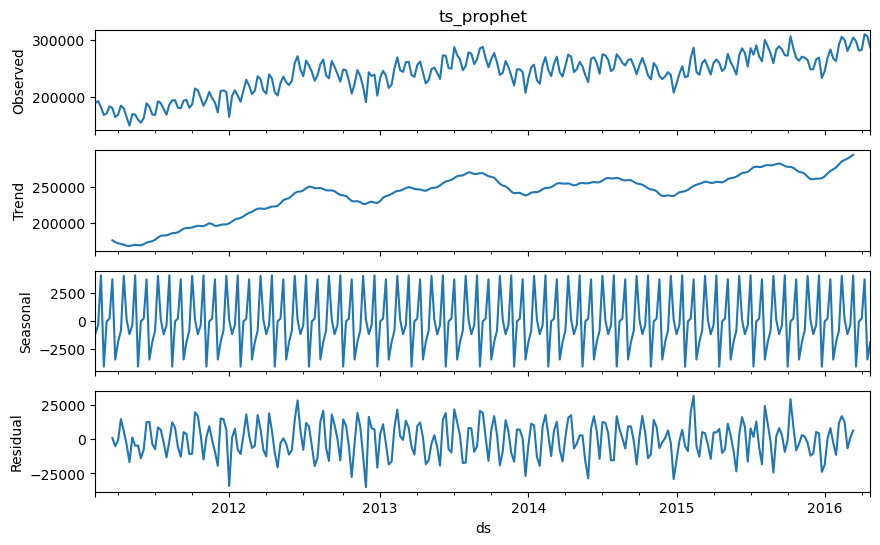

In [16]:
# para utilizar seasonal_decompose, debemos pasarle un pandas series con ds (formato fecha) en el índice
decompose_ts(ts_to_decompose = ts_prophet, period = 12, title = "ts_prophet")

In [17]:
# Para el fit 'ds' no tiene que estar como índice
ts_prophet.reset_index(inplace=True)

In [18]:
prophet = Prophet()

# entrenamos nuestro modelo
prophet.fit(ts_prophet)

# preparamos un df para la predicción futura
# prophet nos da la función auxiliar de make_future_dataframe
# que permite generar automáticamente los periodos necesarios para el forecast futuro
future_df = prophet.make_future_dataframe(periods = 4, freq = "W", include_history = True)

# hacemos la predicción
y_pred_prophet = prophet.predict(future_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future_df

ds
0   2011-02-06
1   2011-02-13
2   2011-02-20
3   2011-02-27
4   2011-03-06
..         ...
272 2016-04-24
273 2016-05-01
274 2016-05-08
275 2016-05-15
276 2016-05-22

[277 rows x 1 columns]

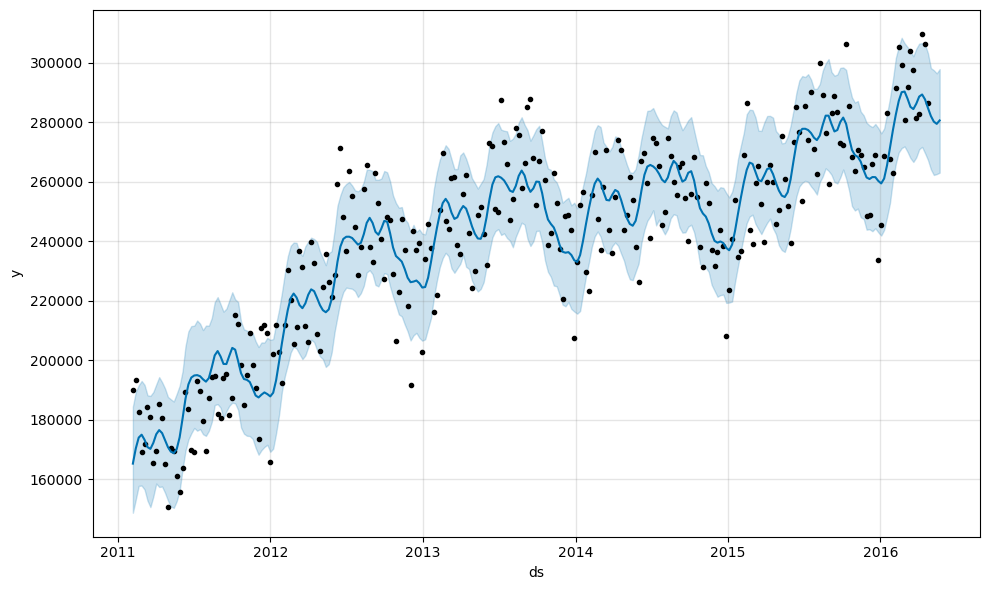

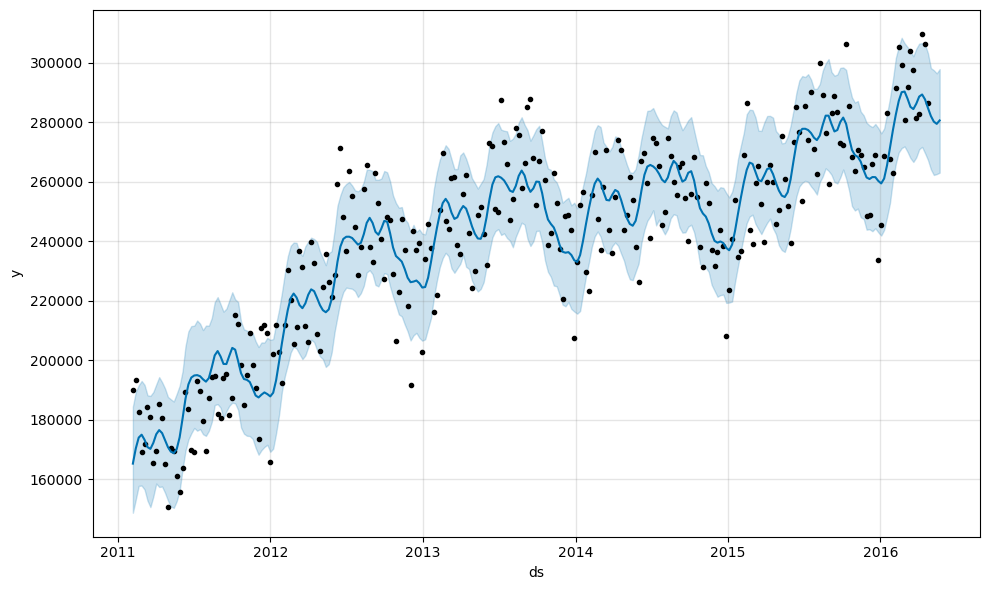

In [20]:
prophet.plot(y_pred_prophet)

In [21]:
ts_prophet['ds'].max()

Timestamp('2016-04-24 00:00:00')

In [22]:
y_pred_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6) #(incluye todo mayo)

#yhat: the forecasted value of our metric (the predicted values of a value y)

#yhat_lower: the lower bound of our forecasts

#yhat_upper: the upper bound of our forecasts

ds           yhat     yhat_lower     yhat_upper
271 2016-04-17  287645.850772  269563.773954  306108.111663
272 2016-04-24  284760.684366  267286.275553  303176.215299
273 2016-05-01  282065.900537  264137.410887  298185.476368
274 2016-05-08  280186.947269  262250.559329  297462.471251
275 2016-05-15  279434.791728  262554.543587  296426.552485
276 2016-05-22  280583.528079  263022.260391  297854.474079

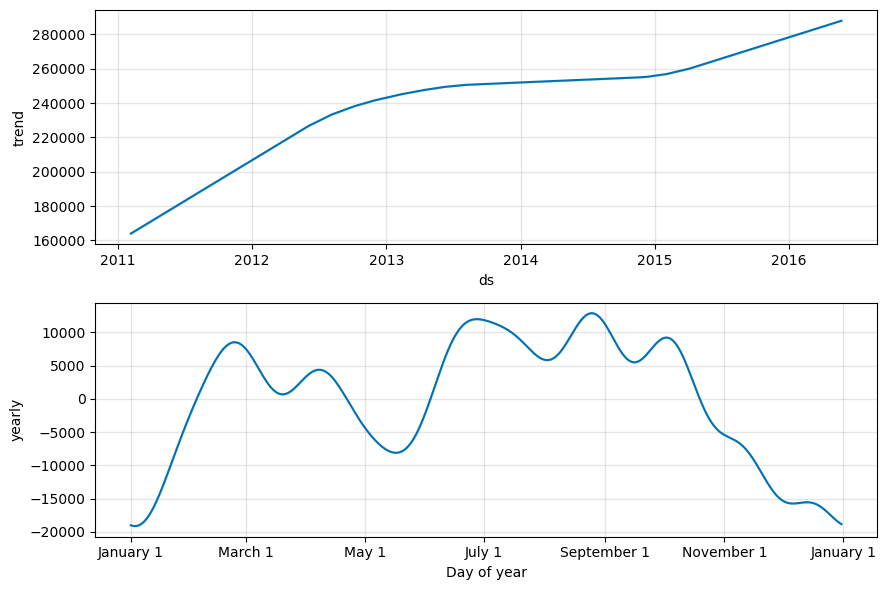

In [23]:
ig_1=prophet.plot_components(y_pred_prophet)
# The value in the plot for any particular day is how much y is added
# to the trend on that day, just due to weekly seasonality. Entonces,
# cada mayo agregamos 10000 al trend para la weekly seasonality y cada
# mayo restamos -20000. Lo podemos pensar, para cada semana, el cambio
# que habría e "y" si no hubiese weekly seasonality.

### Holt Winters

In [24]:
ts_all_sales = ts_prophet.set_index('ds')
ts_all_sales.indexname = None

In [25]:
ts_all_sales.rename(columns={'weekly_sales':'y'}, inplace = True)
ts_all_sales

y
ds                
2011-02-06  189942
2011-02-13  193170
2011-02-20  182569
2011-02-27  169002
2011-03-06  171820
...            ...
2016-03-27  281241
2016-04-03  282697
2016-04-10  309668
2016-04-17  306203
2016-04-24  286524

[273 rows x 1 columns]

In [26]:
#ts_all_sales_train = ts_all_sales[:-4]
#ts_all_sales_valida = ts_all_sales[-4:]

In [27]:
hw_model = ExponentialSmoothing(
    #endog = ts_all_sales_train["y"],
    endog = ts_all_sales["y"],
    trend = "add", # aditivo 
    seasonal = "add", # aditivo
    seasonal_periods = 4 # ojo que debemos saber nuestros periodos. Hay que visualizar la TS y determinarlo
)

hw_model_fitted = hw_model.fit()
hw_model_fittedvalues = hw_model_fitted.fittedvalues

ts_all_sales["y_fitted"] = hw_model_fittedvalues

hw_model_forecast4 = hw_model_fitted.forecast(steps = 4)

c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [28]:
ts_all_sales

y       y_fitted
ds                               
2011-02-06  189942  172432.776136
2011-02-13  193170  188111.409975
2011-02-20  182569  188600.588765
2011-02-27  169002  175306.917705
2011-03-06  171820  185005.724762
...            ...            ...
2016-03-27  281241  279189.431927
2016-04-03  282697  292448.434145
2016-04-10  309668  304111.850653
2016-04-17  306203  299012.638582
2016-04-24  286524  283664.593076

[273 rows x 2 columns]

In [57]:
MSE = np.square(np.subtract(ts_all_sales['y'],ts_all_sales['y_fitted'])).mean()
RMSE = np.sqrt(MSE)
RMSE

13015.154943546357

In [29]:
# Nuestra predicción
hw_model_forecast4

2016-05-01    287445.308416
2016-05-08    313492.232150
2016-05-15    308775.478015
2016-05-22    286252.819773
Freq: W-SUN, dtype: float64

In [30]:
hw_model.params

{'smoothing_level': 0.1817857142857143,
 'smoothing_trend': 0.03029761904761905,
 'smoothing_seasonal': 0.8182142857142857,
 'damping_trend': nan,
 'initial_level': 180871.1916666666,
 'initial_trend': -995.3530303030188,
 'initial_seasons': array([-7443.0625 ,  5951.5625 ,  6392.21875, -4900.71875]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [31]:
ts_all_sales_fitted_forecasted = ts_all_sales["y_fitted"].append(hw_model_forecast4)

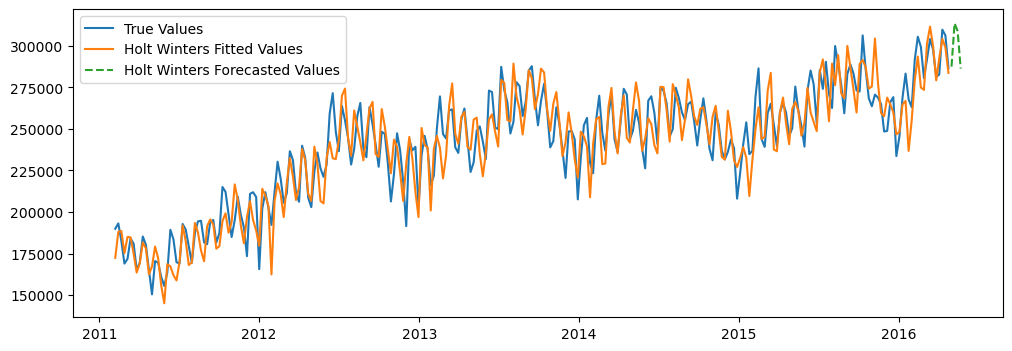

In [32]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot()

ax.plot(ts_all_sales["y"], label = "True Values")
ax.plot(hw_model_fittedvalues, label = "Holt Winters Fitted Values")
ax.plot(hw_model_forecast4, label = "Holt Winters Forecasted Values", ls = '--')

plt.legend()

In [33]:
hw_model_forecast4

2016-05-01    287445.308416
2016-05-08    313492.232150
2016-05-15    308775.478015
2016-05-22    286252.819773
Freq: W-SUN, dtype: float64

In [34]:
ts_all_sales.tail(5)

y       y_fitted
ds                               
2016-03-27  281241  279189.431927
2016-04-03  282697  292448.434145
2016-04-10  309668  304111.850653
2016-04-17  306203  299012.638582
2016-04-24  286524  283664.593076

### Modelo de predicción sobre los 100 objetos mas vendidos

In [35]:
topsales_100 = df.groupby('id')['weekly_sales'].sum().sort_values(ascending = False).head(100).keys()
topsales_100

Index(['SUPERMARKET_3_090_NYC_3', 'SUPERMARKET_3_586_BOS_2',
       'SUPERMARKET_3_586_BOS_3', 'SUPERMARKET_3_586_NYC_3',
       'SUPERMARKET_3_090_NYC_1', 'SUPERMARKET_3_090_PHI_3',
       'SUPERMARKET_3_090_BOS_2', 'SUPERMARKET_3_090_BOS_3',
       'SUPERMARKET_3_252_BOS_2', 'SUPERMARKET_3_586_BOS_1',
       'SUPERMARKET_3_226_PHI_3', 'SUPERMARKET_3_555_BOS_2',
       'SUPERMARKET_3_090_BOS_1', 'SUPERMARKET_3_120_NYC_3',
       'SUPERMARKET_3_586_NYC_1', 'SUPERMARKET_3_252_BOS_3',
       'SUPERMARKET_3_586_PHI_3', 'SUPERMARKET_3_694_PHI_3',
       'SUPERMARKET_3_252_NYC_3', 'SUPERMARKET_3_541_NYC_3',
       'SUPERMARKET_3_635_NYC_3', 'SUPERMARKET_3_226_PHI_1',
       'SUPERMARKET_3_555_BOS_3', 'SUPERMARKET_3_252_NYC_1',
       'SUPERMARKET_3_377_BOS_3', 'SUPERMARKET_3_808_NYC_3',
       'SUPERMARKET_3_587_NYC_3', 'SUPERMARKET_3_226_PHI_2',
       'SUPERMARKET_3_555_BOS_1', 'SUPERMARKET_3_586_NYC_2',
       'SUPERMARKET_3_377_BOS_2', 'SUPERMARKET_3_120_NYC_1',
       'SUPERMARKET_3_69

In [36]:
# Agrupación necesaria para lanzar el ploteo
df_topsales_100 = df.groupby('id')

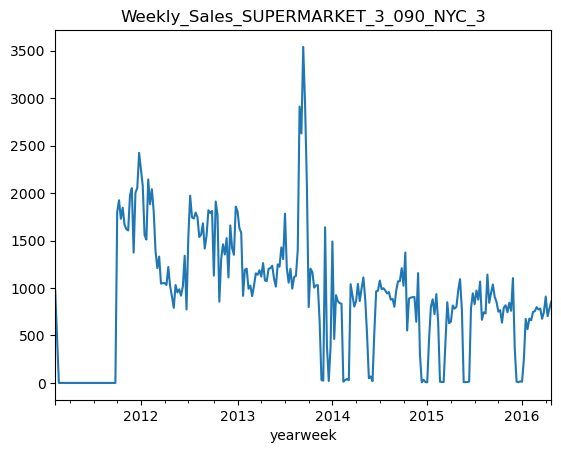

<Figure size 1200x200 with 0 Axes>

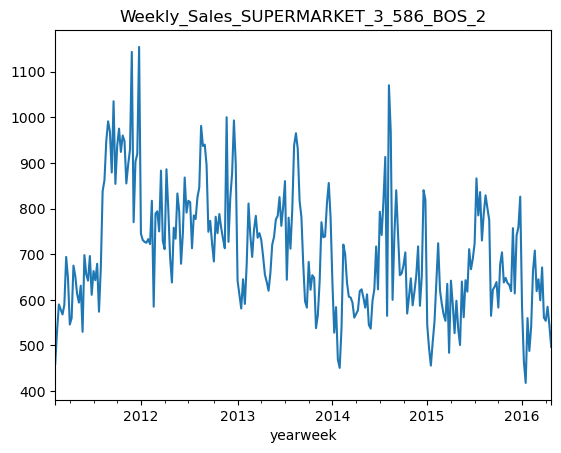

<Figure size 1200x200 with 0 Axes>

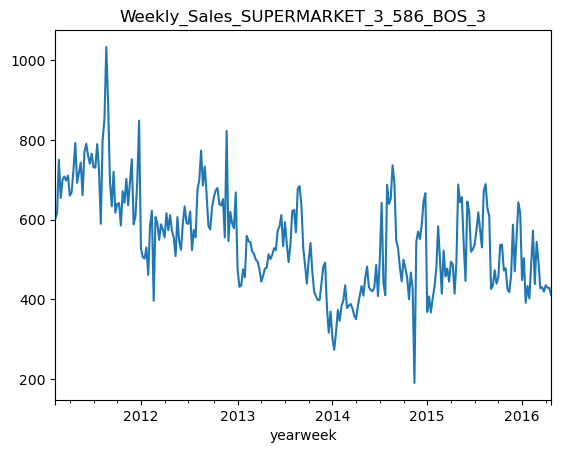

<Figure size 1200x200 with 0 Axes>

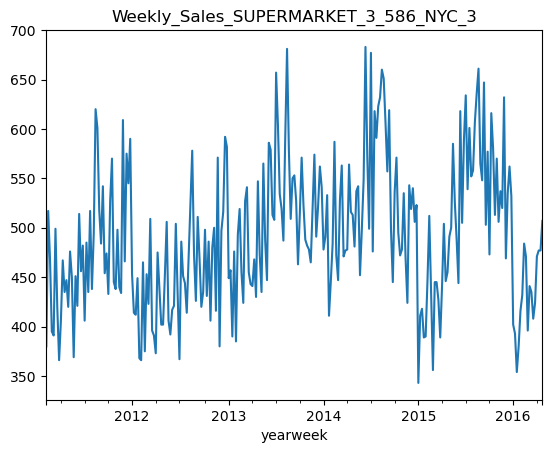

<Figure size 1200x200 with 0 Axes>

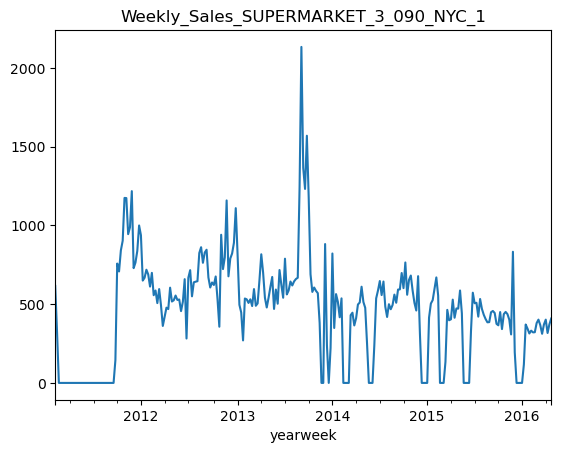

<Figure size 1200x200 with 0 Axes>

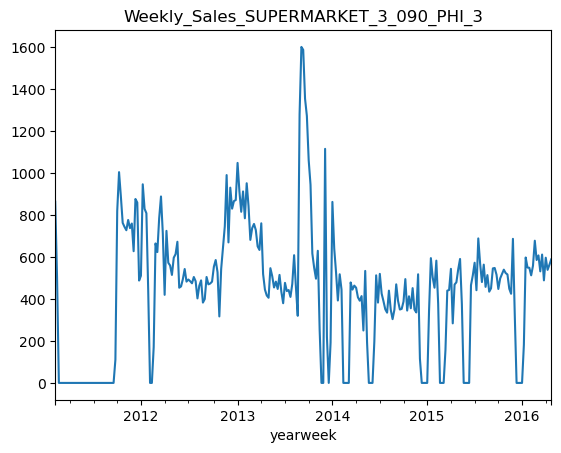

<Figure size 1200x200 with 0 Axes>

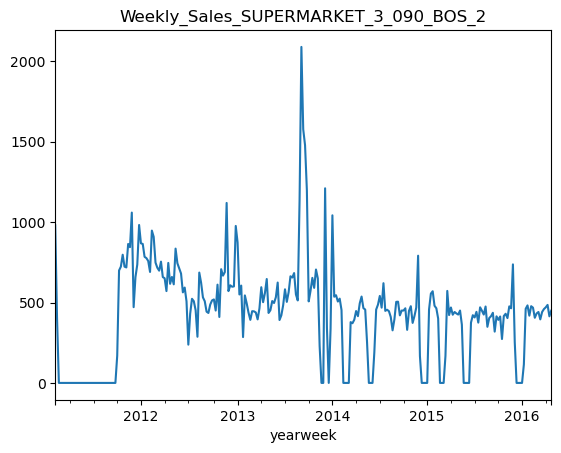

<Figure size 1200x200 with 0 Axes>

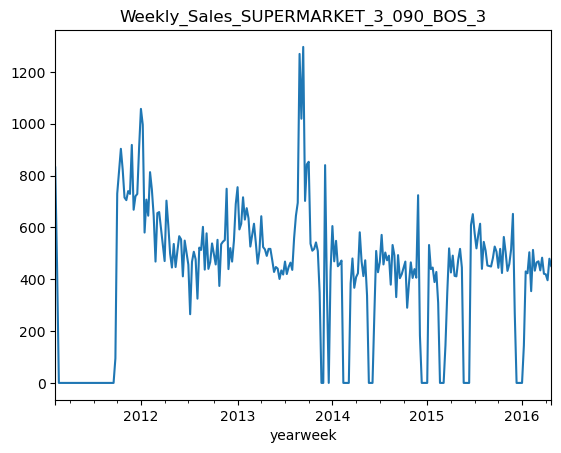

<Figure size 1200x200 with 0 Axes>

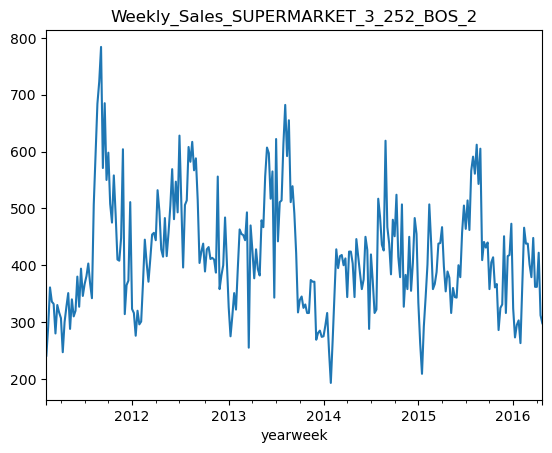

<Figure size 1200x200 with 0 Axes>

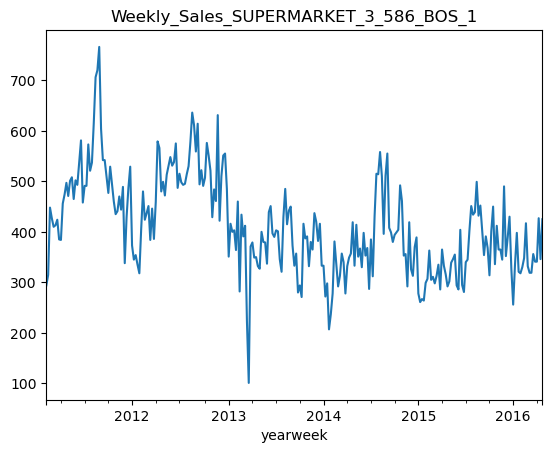

<Figure size 1200x200 with 0 Axes>

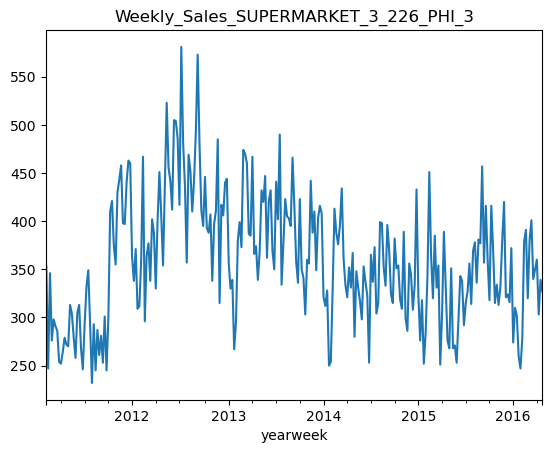

<Figure size 1200x200 with 0 Axes>

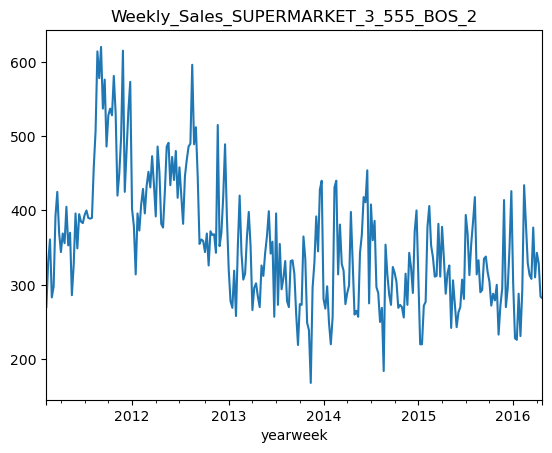

<Figure size 1200x200 with 0 Axes>

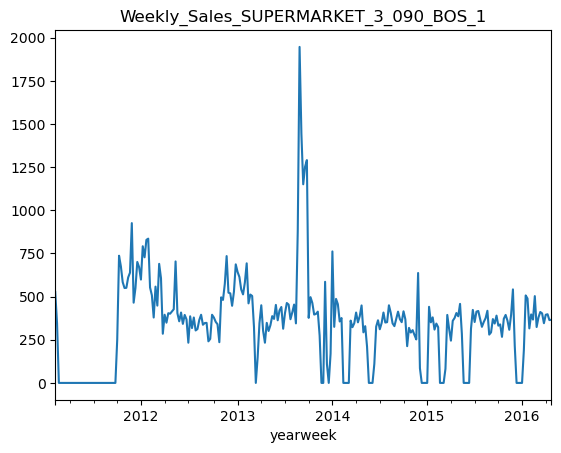

<Figure size 1200x200 with 0 Axes>

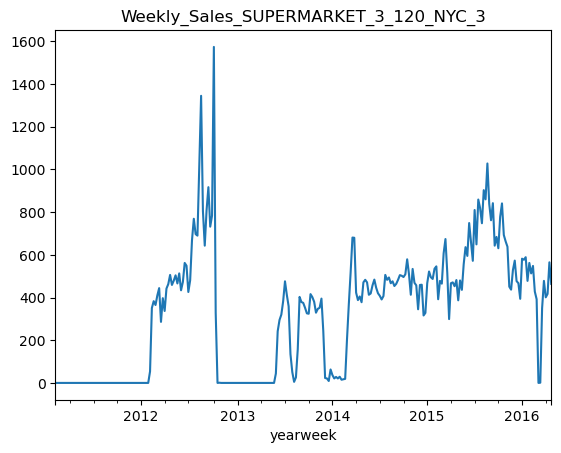

<Figure size 1200x200 with 0 Axes>

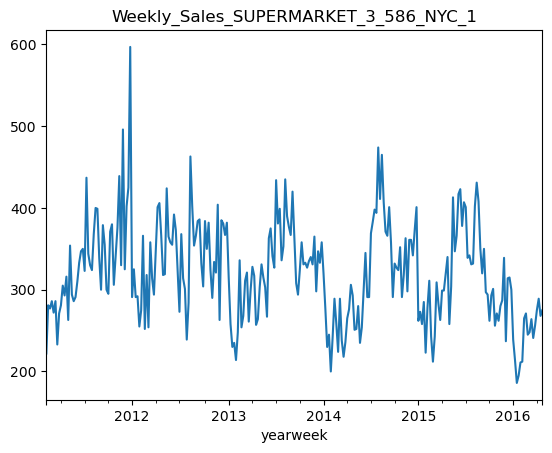

<Figure size 1200x200 with 0 Axes>

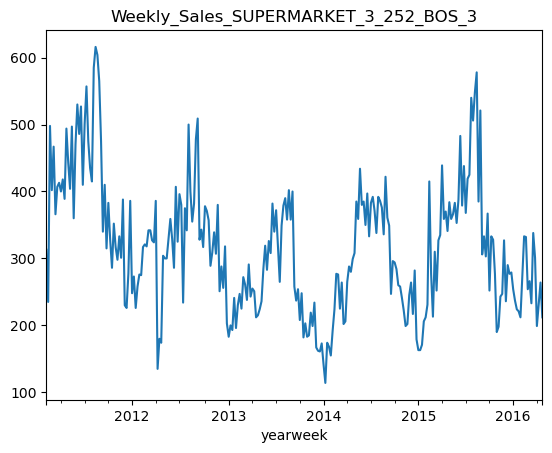

<Figure size 1200x200 with 0 Axes>

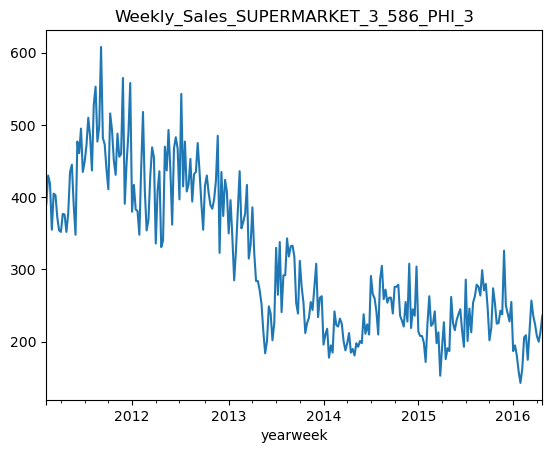

<Figure size 1200x200 with 0 Axes>

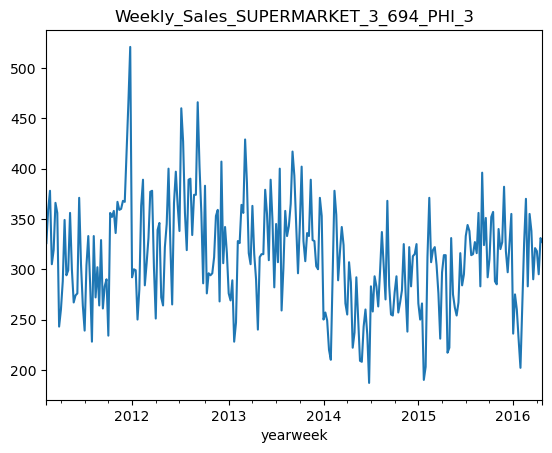

<Figure size 1200x200 with 0 Axes>

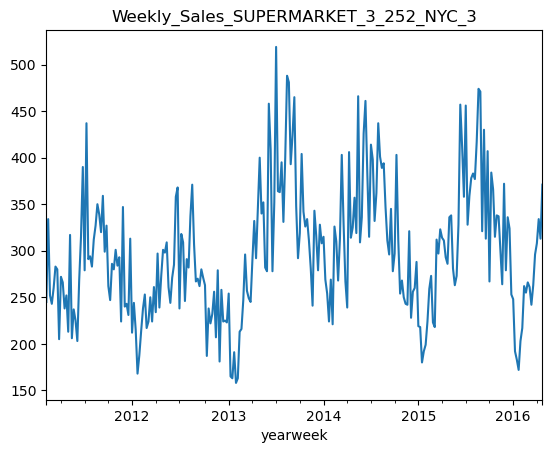

<Figure size 1200x200 with 0 Axes>

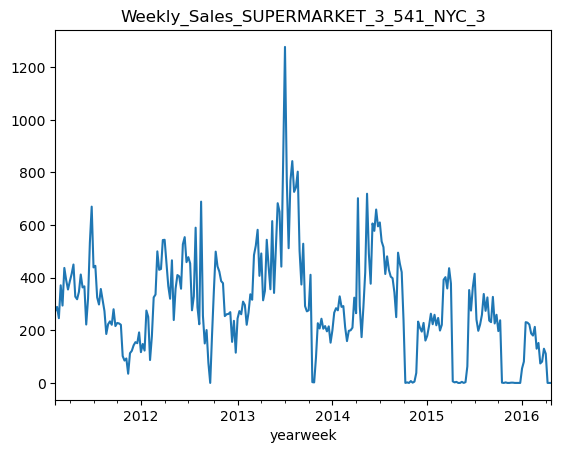

<Figure size 1200x200 with 0 Axes>

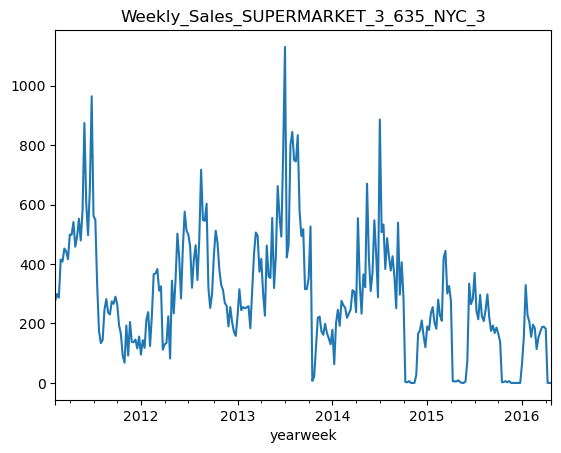

<Figure size 1200x200 with 0 Axes>

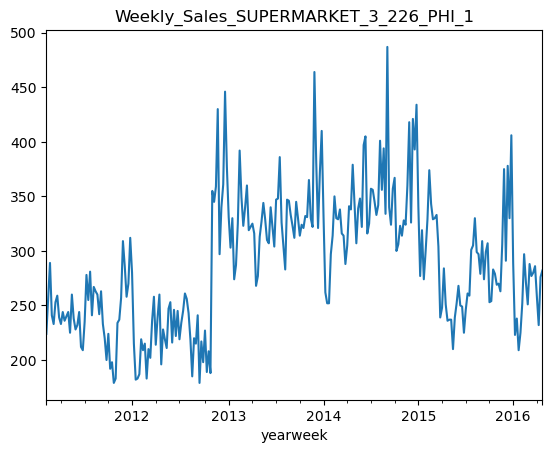

<Figure size 1200x200 with 0 Axes>

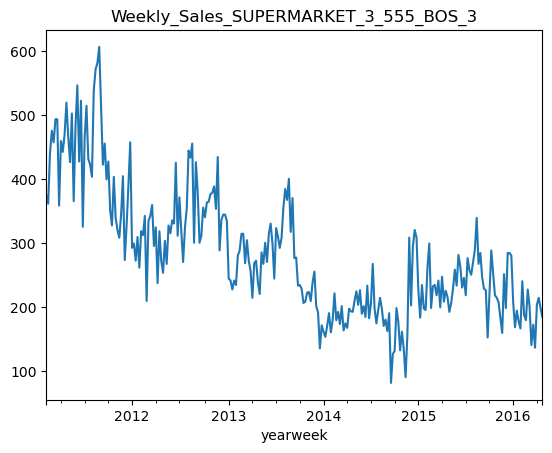

<Figure size 1200x200 with 0 Axes>

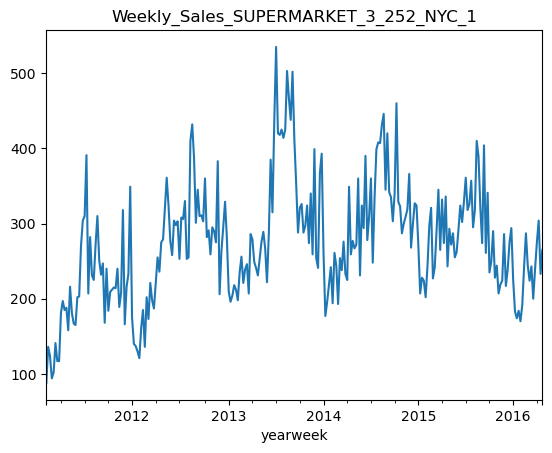

<Figure size 1200x200 with 0 Axes>

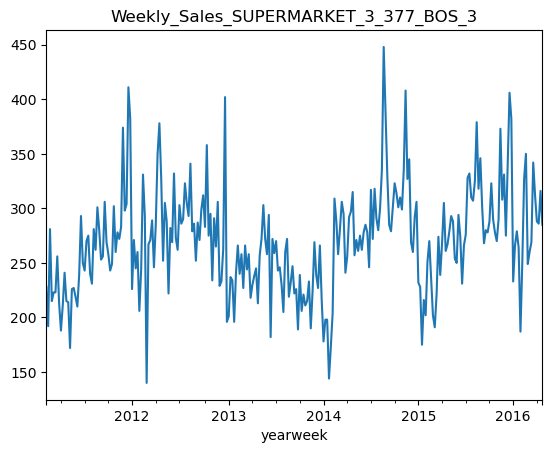

<Figure size 1200x200 with 0 Axes>

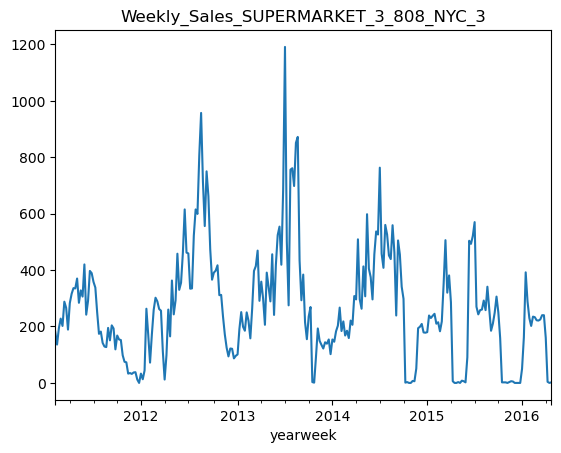

<Figure size 1200x200 with 0 Axes>

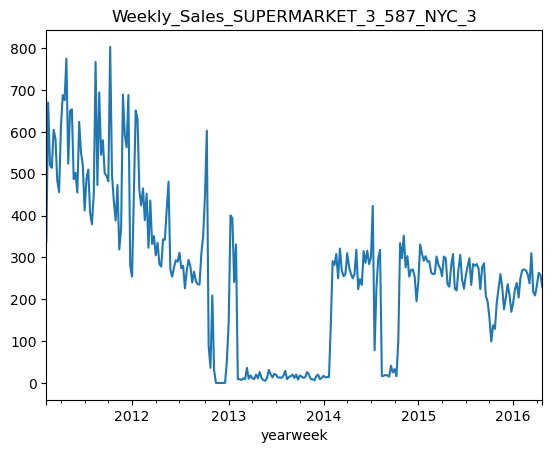

<Figure size 1200x200 with 0 Axes>

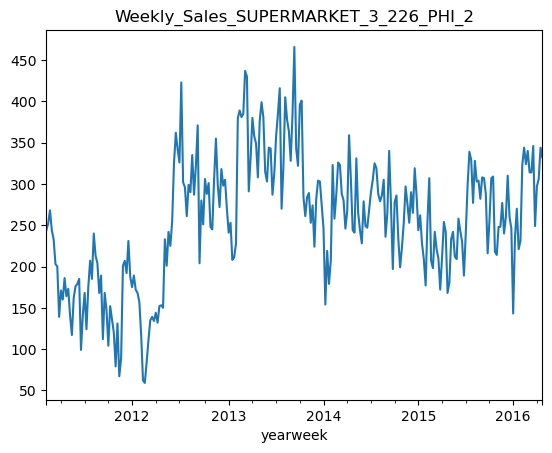

<Figure size 1200x200 with 0 Axes>

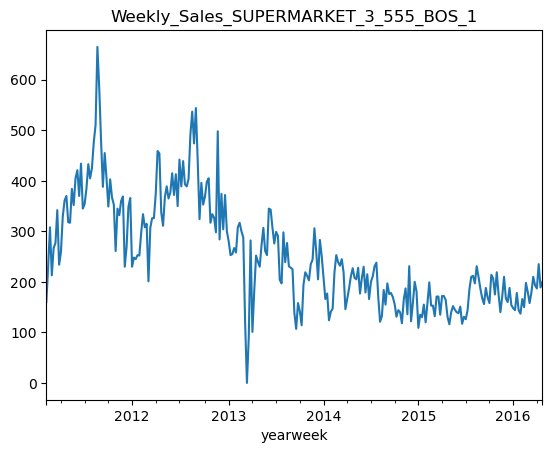

<Figure size 1200x200 with 0 Axes>

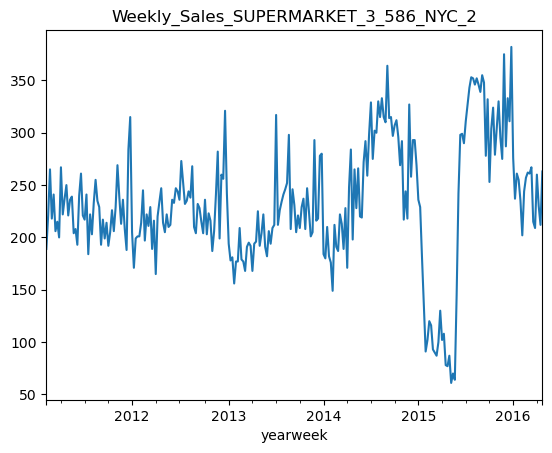

<Figure size 1200x200 with 0 Axes>

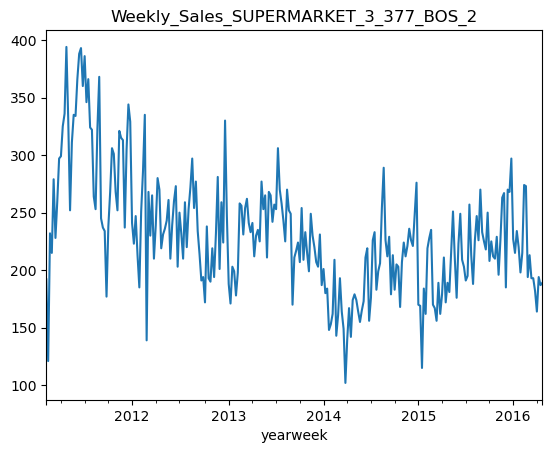

<Figure size 1200x200 with 0 Axes>

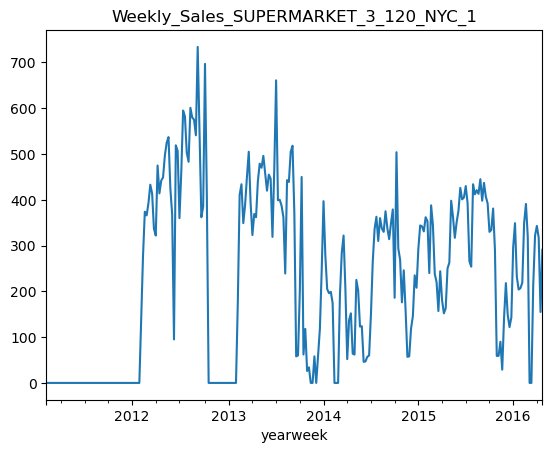

<Figure size 1200x200 with 0 Axes>

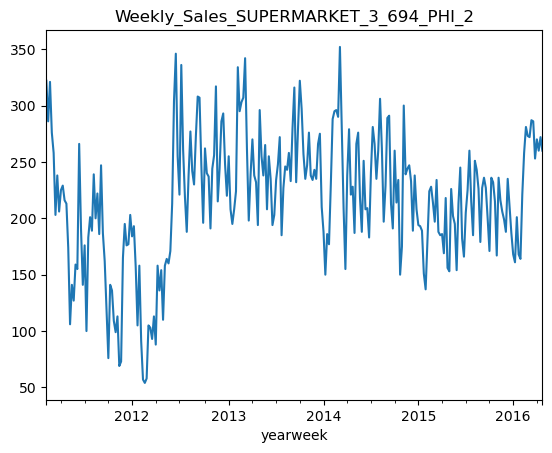

<Figure size 1200x200 with 0 Axes>

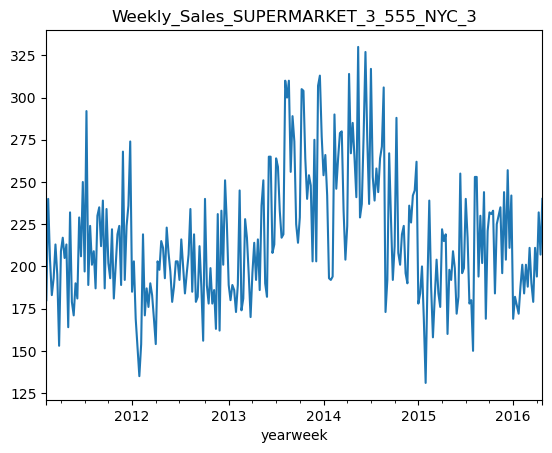

<Figure size 1200x200 with 0 Axes>

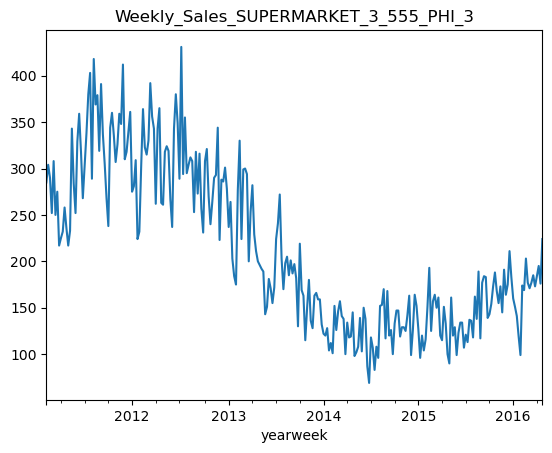

<Figure size 1200x200 with 0 Axes>

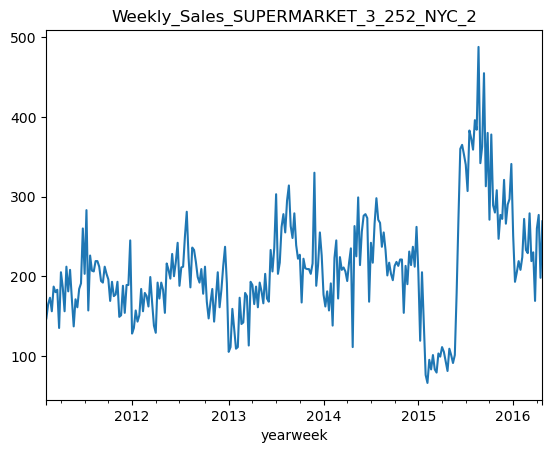

<Figure size 1200x200 with 0 Axes>

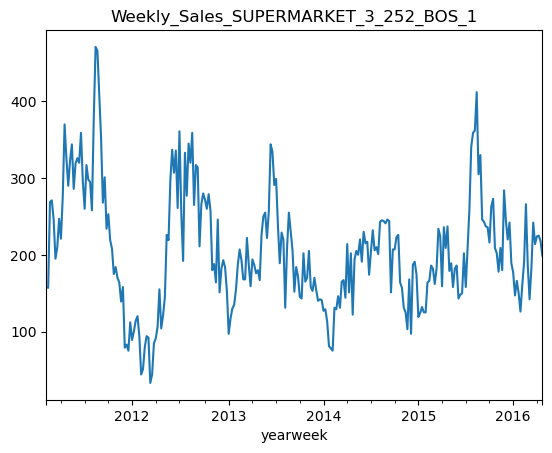

<Figure size 1200x200 with 0 Axes>

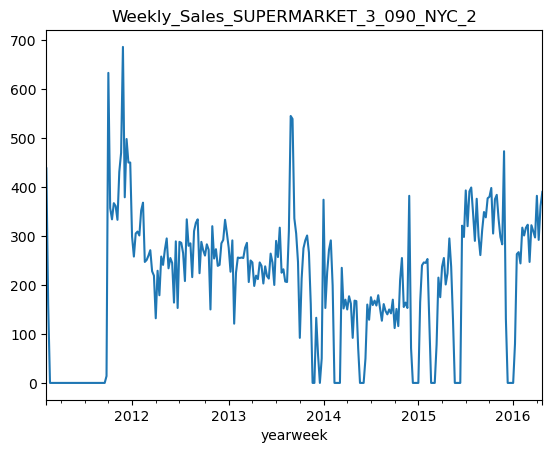

<Figure size 1200x200 with 0 Axes>

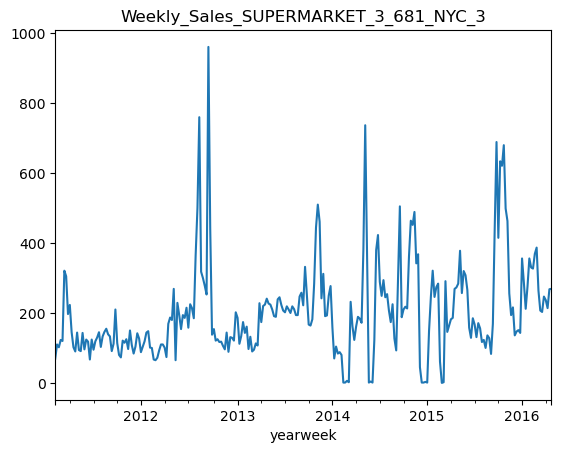

<Figure size 1200x200 with 0 Axes>

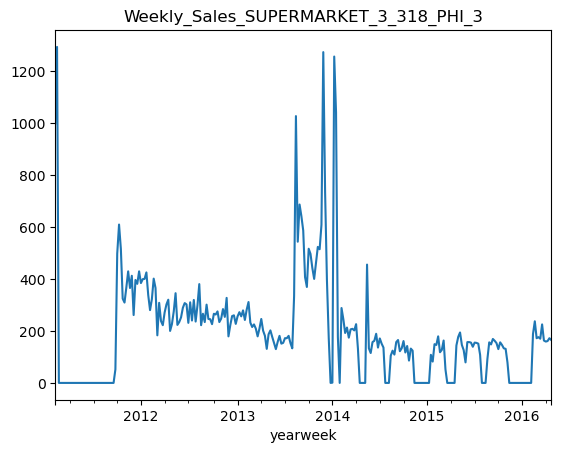

<Figure size 1200x200 with 0 Axes>

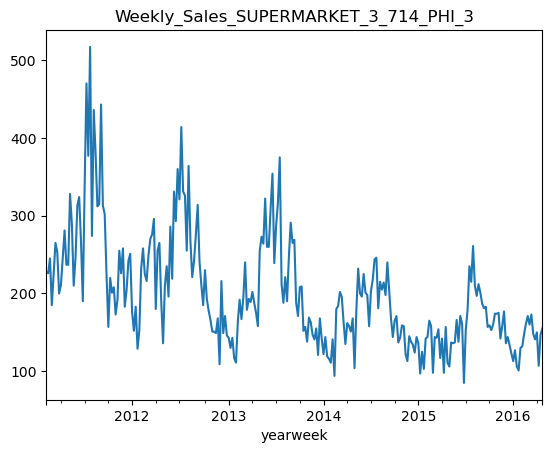

<Figure size 1200x200 with 0 Axes>

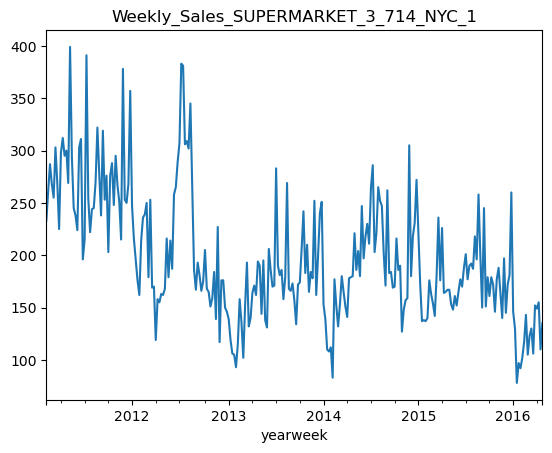

<Figure size 1200x200 with 0 Axes>

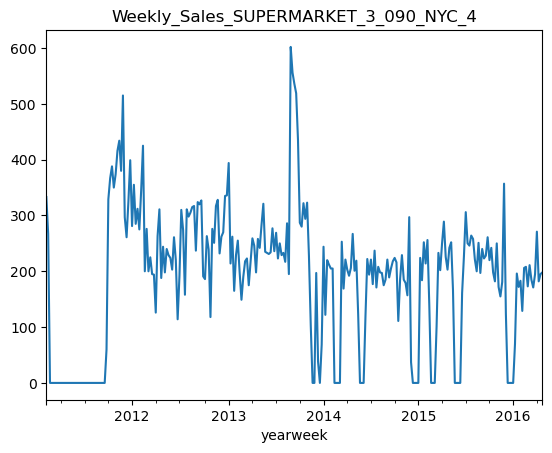

<Figure size 1200x200 with 0 Axes>

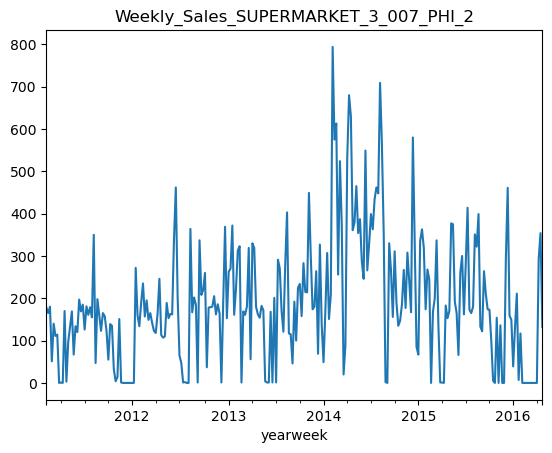

<Figure size 1200x200 with 0 Axes>

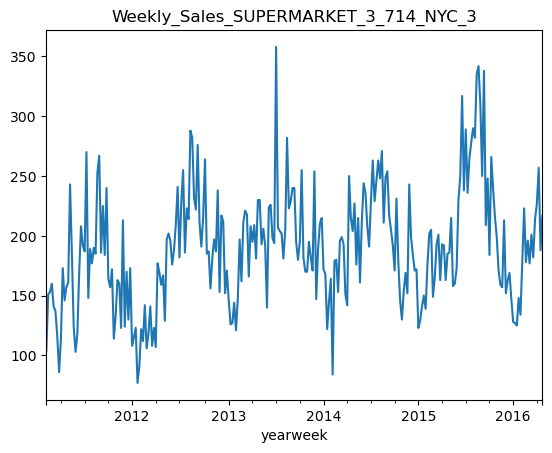

<Figure size 1200x200 with 0 Axes>

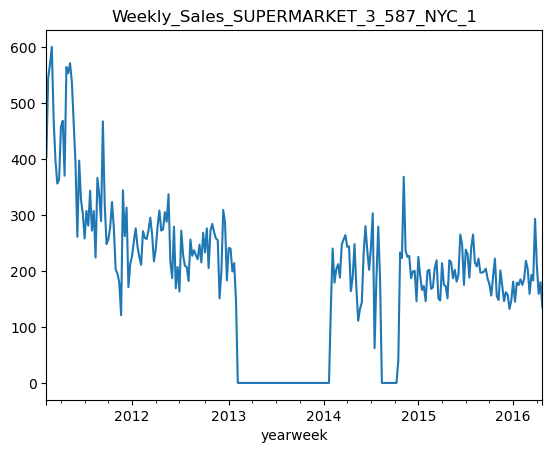

<Figure size 1200x200 with 0 Axes>

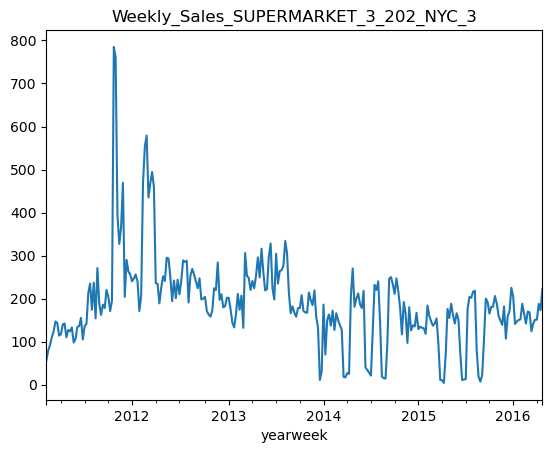

<Figure size 1200x200 with 0 Axes>

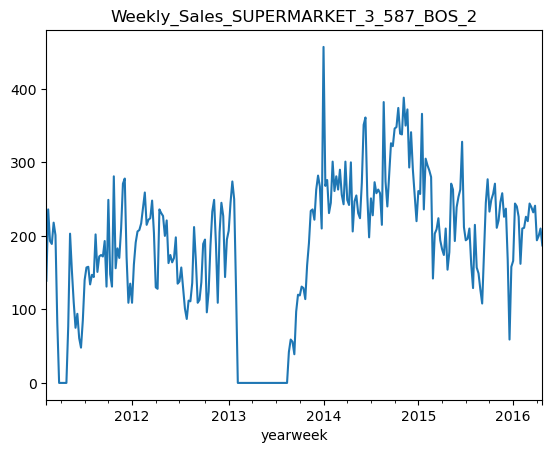

<Figure size 1200x200 with 0 Axes>

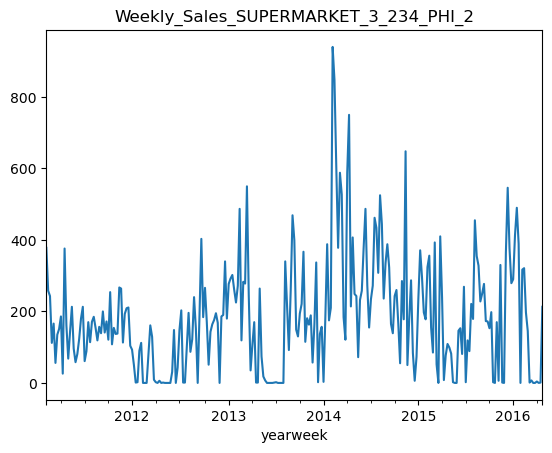

<Figure size 1200x200 with 0 Axes>

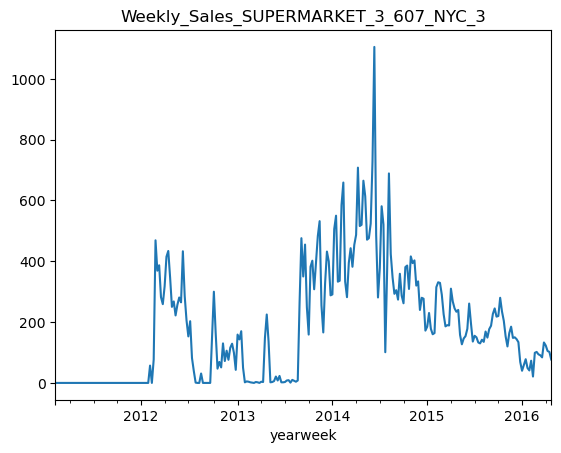

<Figure size 1200x200 with 0 Axes>

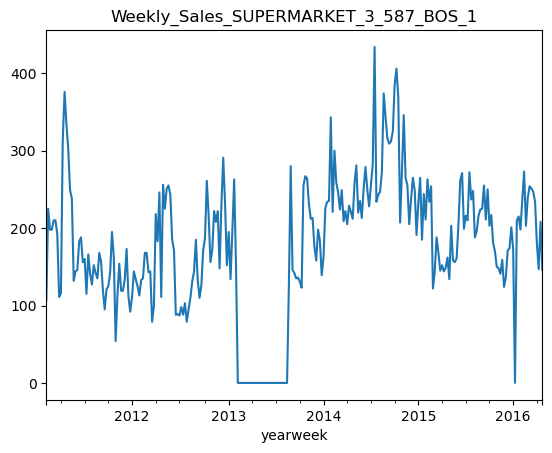

<Figure size 1200x200 with 0 Axes>

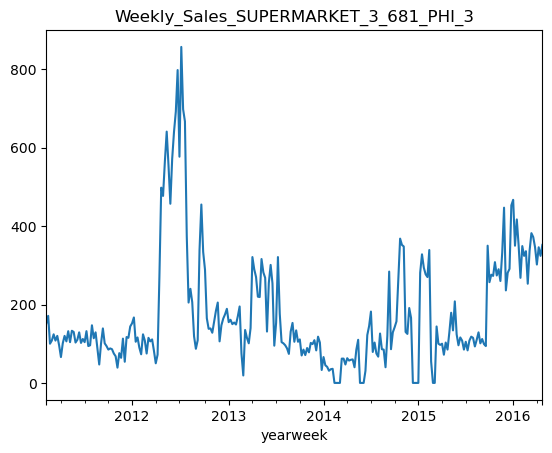

<Figure size 1200x200 with 0 Axes>

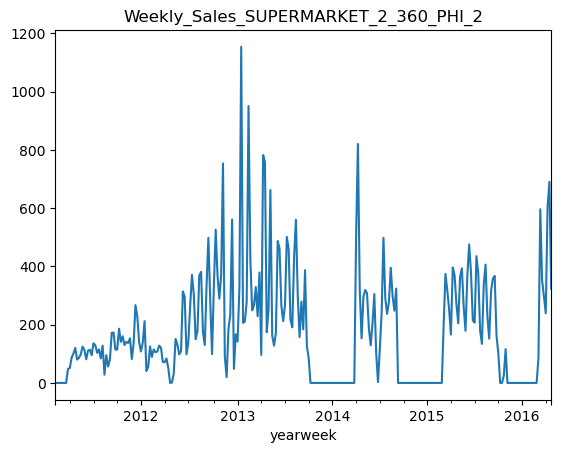

<Figure size 1200x200 with 0 Axes>

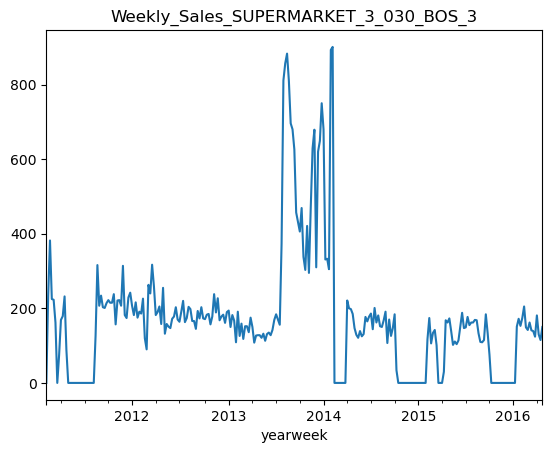

<Figure size 1200x200 with 0 Axes>

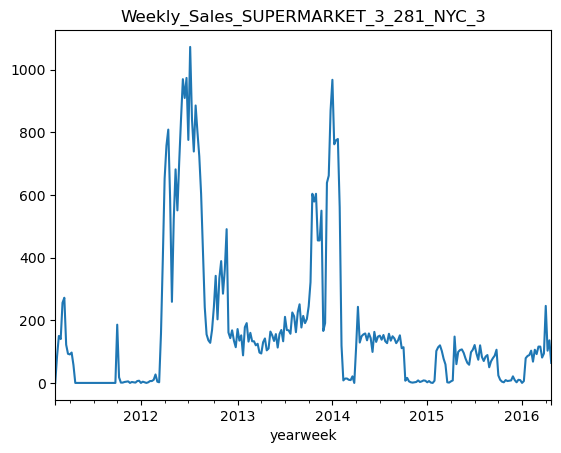

<Figure size 1200x200 with 0 Axes>

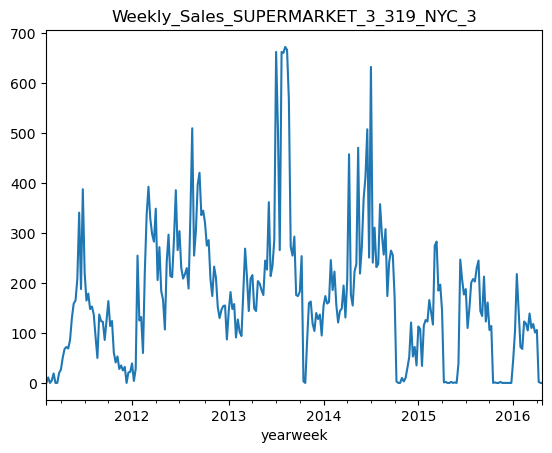

<Figure size 1200x200 with 0 Axes>

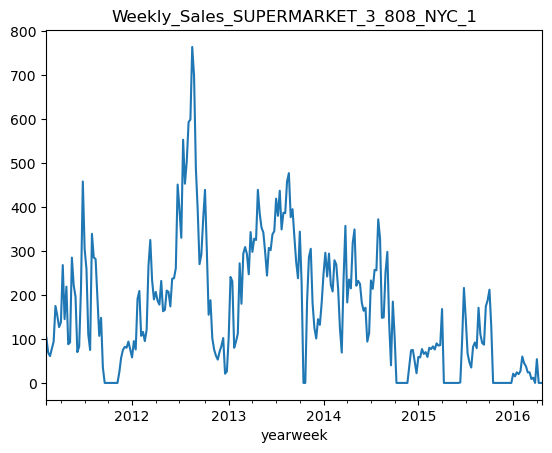

<Figure size 1200x200 with 0 Axes>

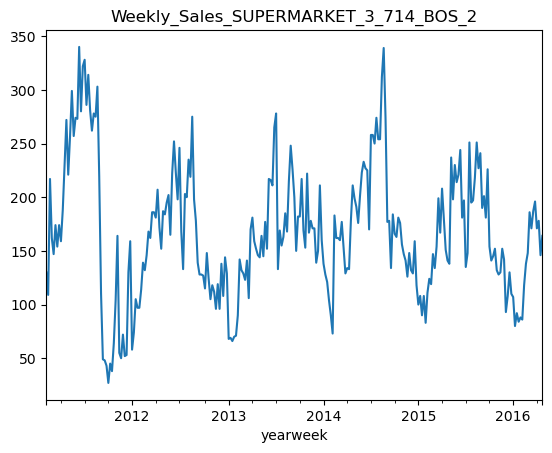

<Figure size 1200x200 with 0 Axes>

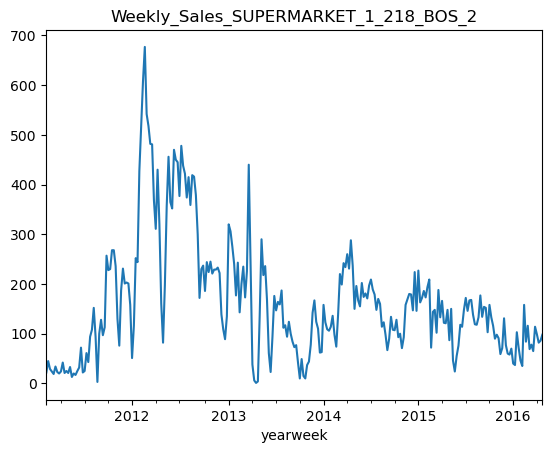

<Figure size 1200x200 with 0 Axes>

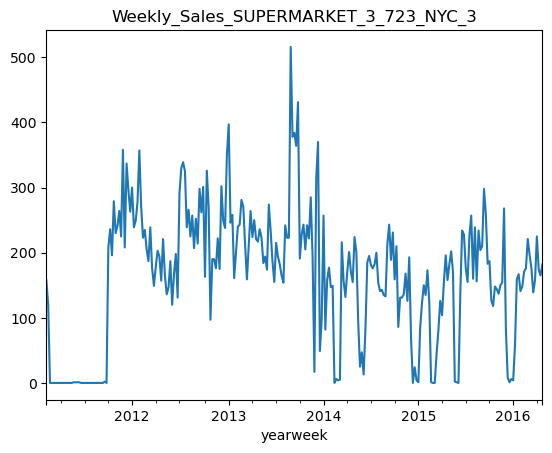

<Figure size 1200x200 with 0 Axes>

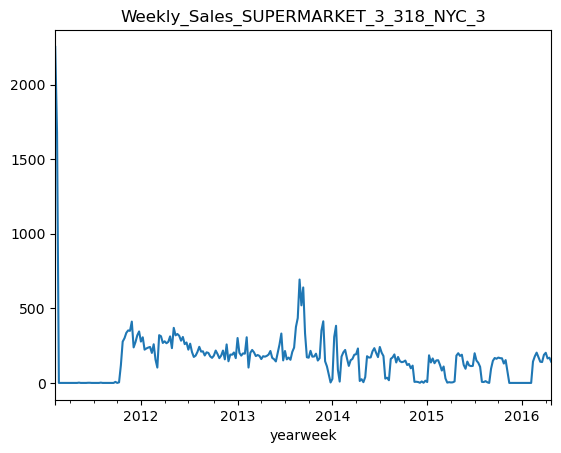

<Figure size 1200x200 with 0 Axes>

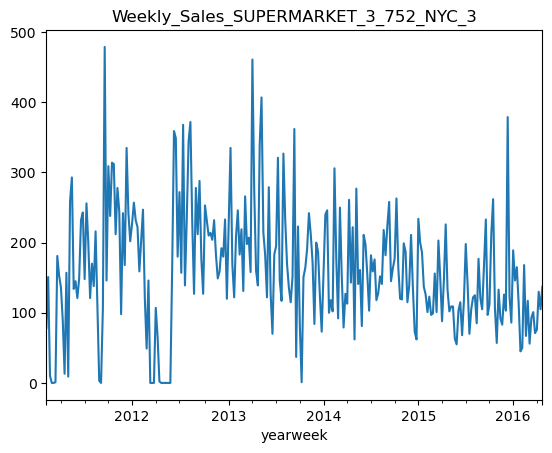

<Figure size 1200x200 with 0 Axes>

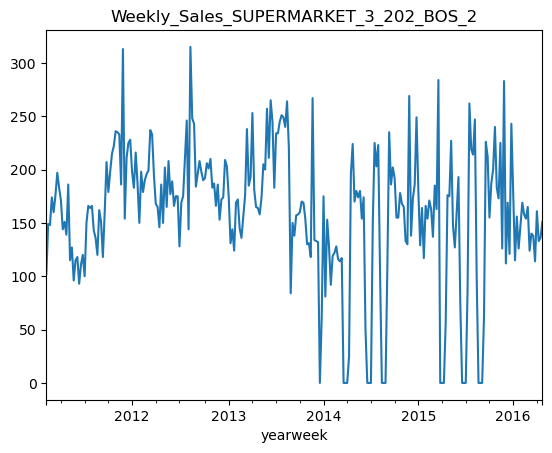

<Figure size 1200x200 with 0 Axes>

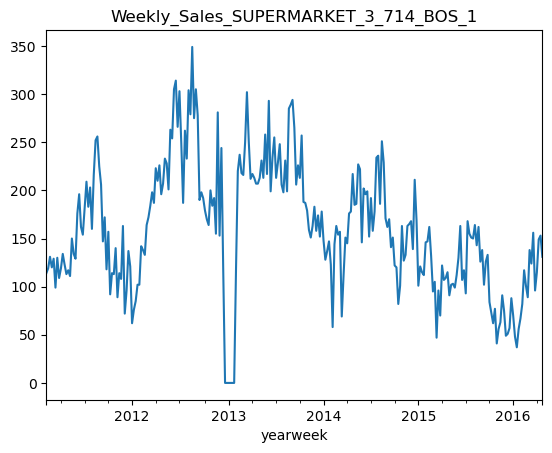

<Figure size 1200x200 with 0 Axes>

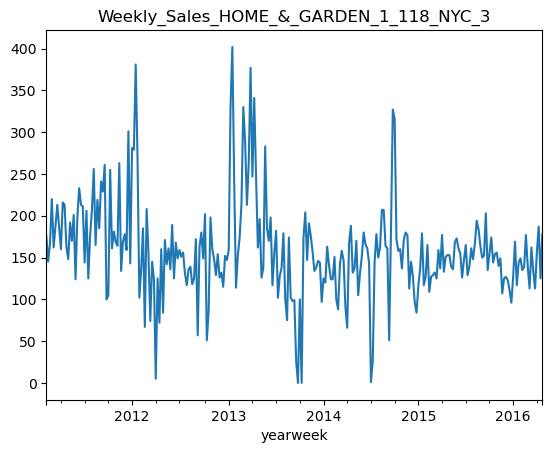

<Figure size 1200x200 with 0 Axes>

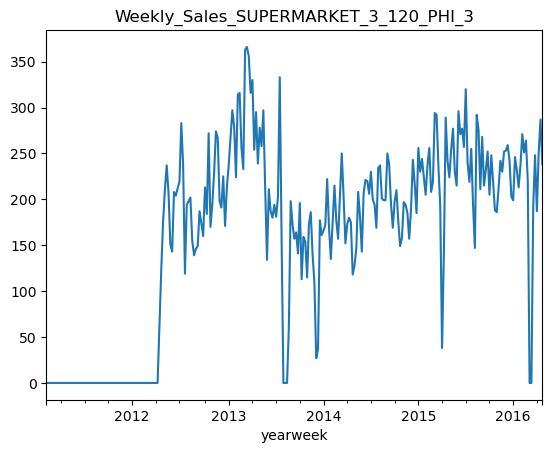

<Figure size 1200x200 with 0 Axes>

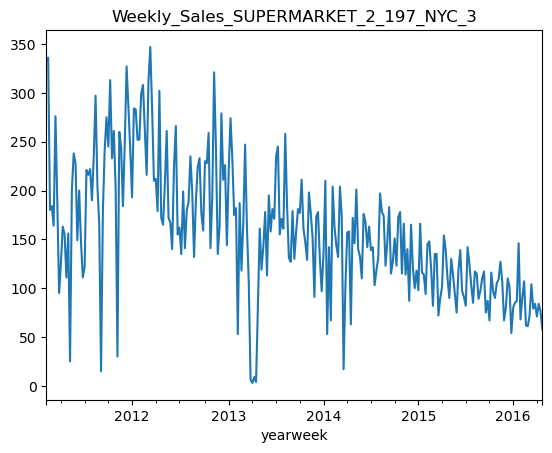

<Figure size 1200x200 with 0 Axes>

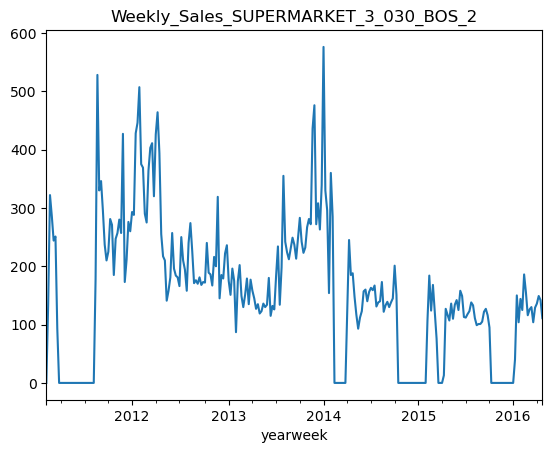

<Figure size 1200x200 with 0 Axes>

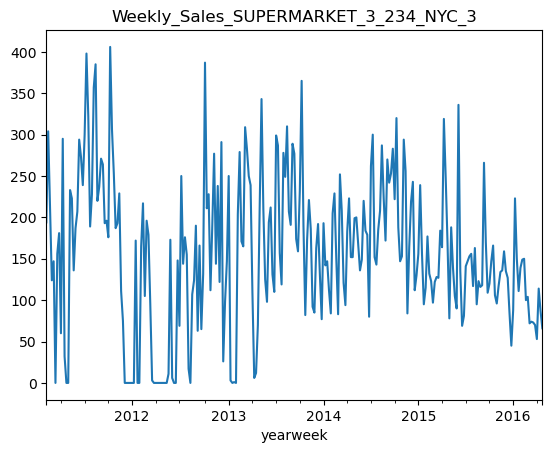

<Figure size 1200x200 with 0 Axes>

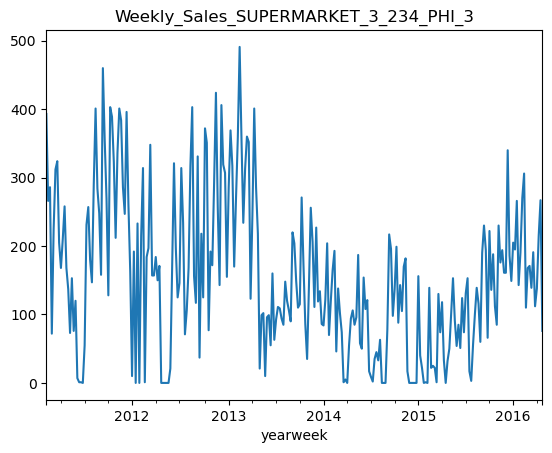

<Figure size 1200x200 with 0 Axes>

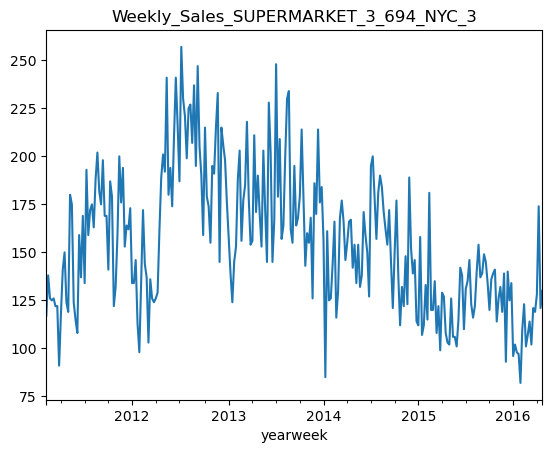

<Figure size 1200x200 with 0 Axes>

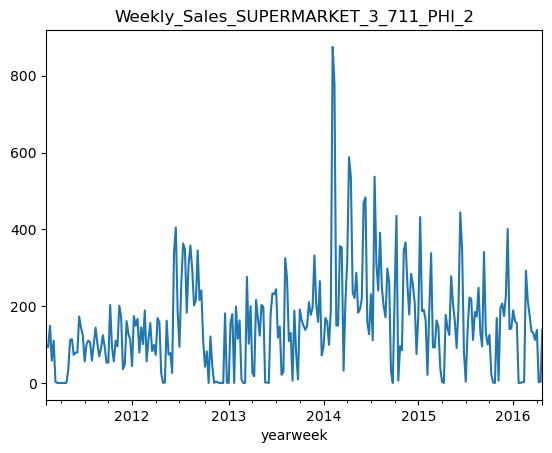

<Figure size 1200x200 with 0 Axes>

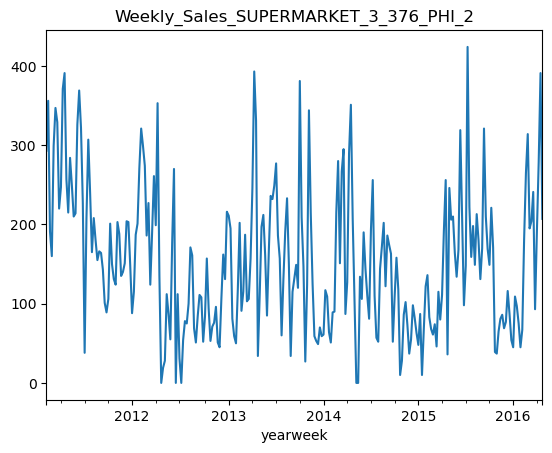

<Figure size 1200x200 with 0 Axes>

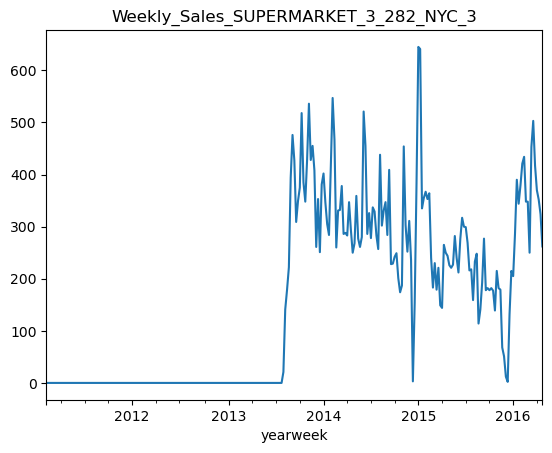

<Figure size 1200x200 with 0 Axes>

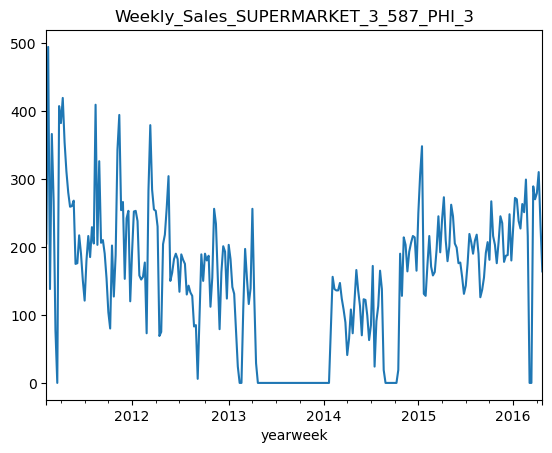

<Figure size 1200x200 with 0 Axes>

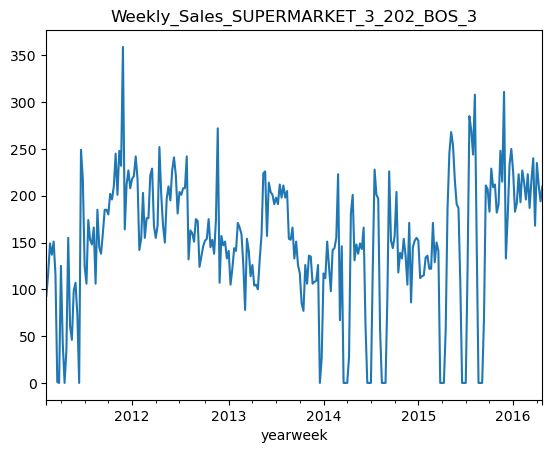

<Figure size 1200x200 with 0 Axes>

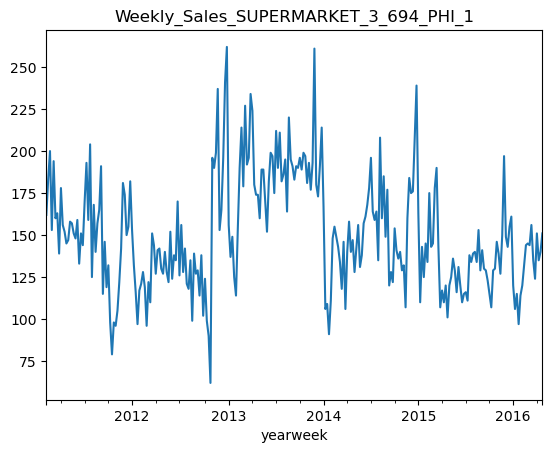

<Figure size 1200x200 with 0 Axes>

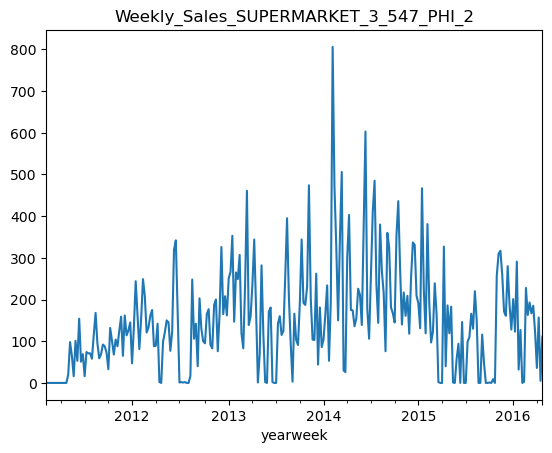

<Figure size 1200x200 with 0 Axes>

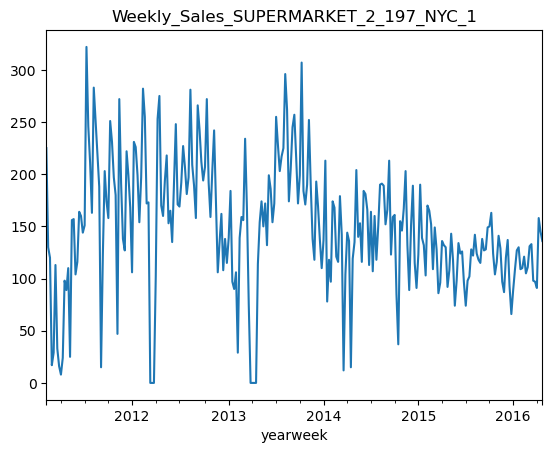

<Figure size 1200x200 with 0 Axes>

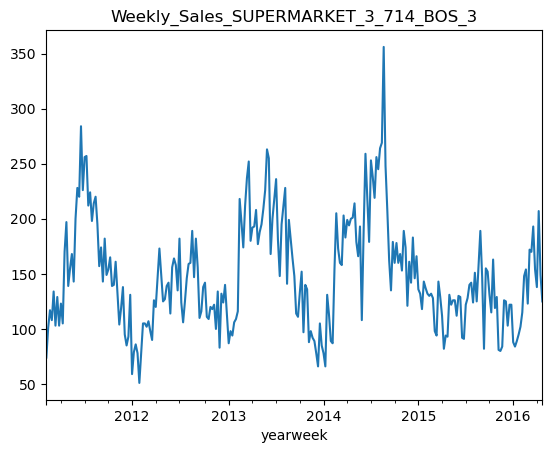

<Figure size 1200x200 with 0 Axes>

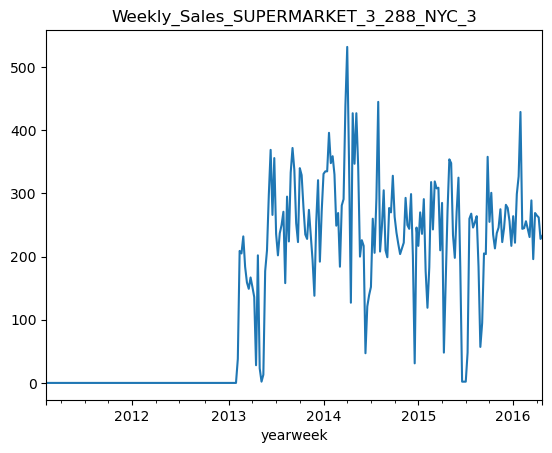

<Figure size 1200x200 with 0 Axes>

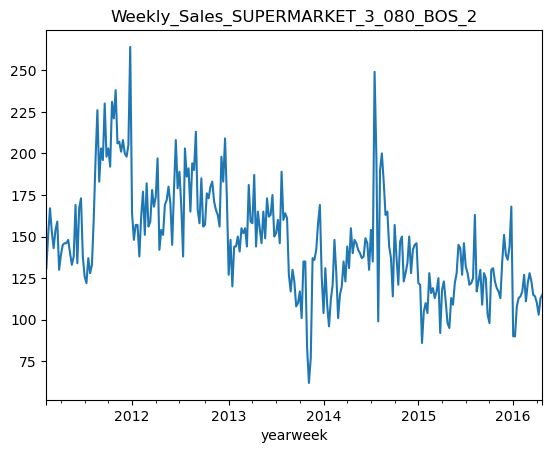

<Figure size 1200x200 with 0 Axes>

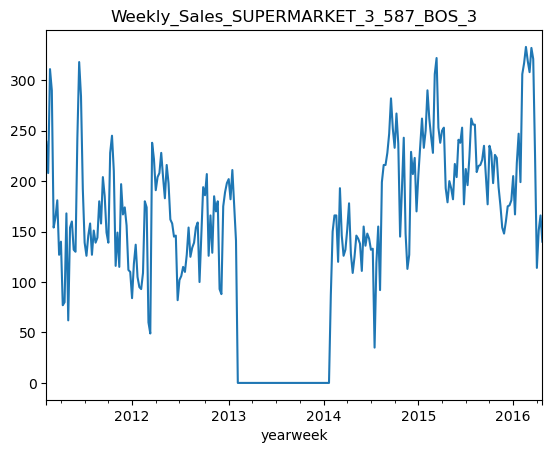

<Figure size 1200x200 with 0 Axes>

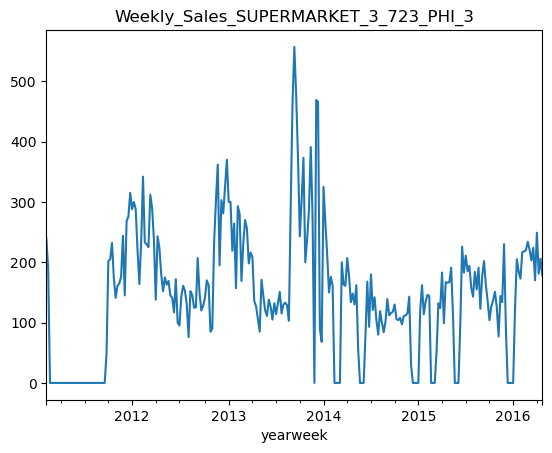

<Figure size 1200x200 with 0 Axes>

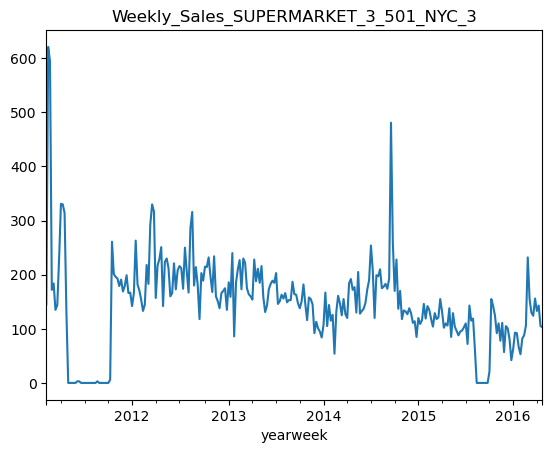

<Figure size 1200x200 with 0 Axes>

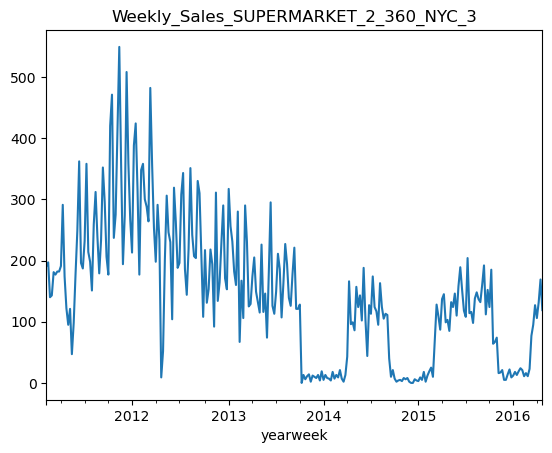

<Figure size 1200x200 with 0 Axes>

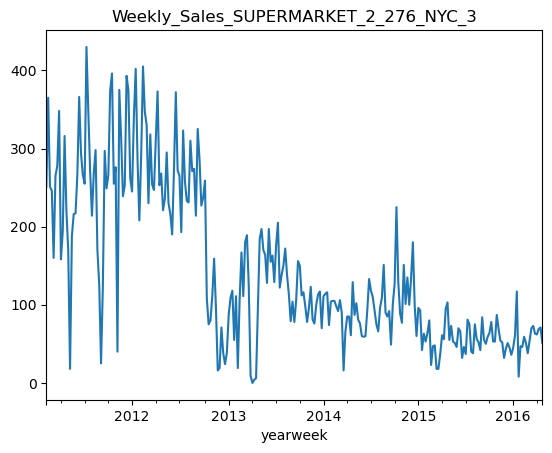

<Figure size 1200x200 with 0 Axes>

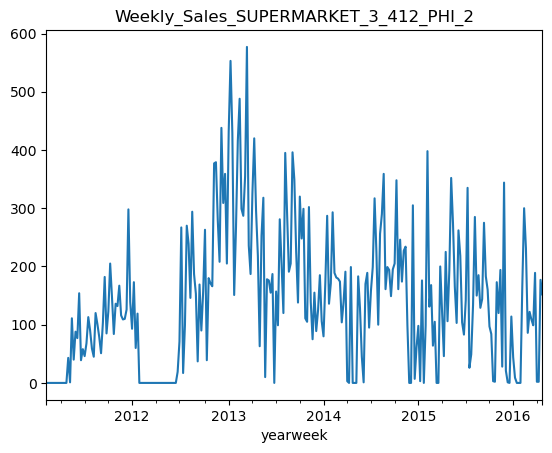

<Figure size 1200x200 with 0 Axes>

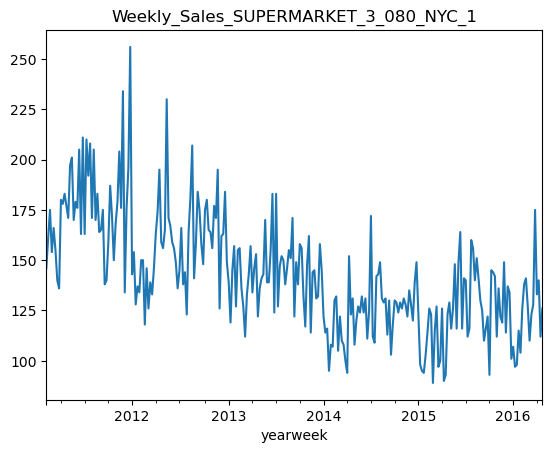

<Figure size 1200x200 with 0 Axes>

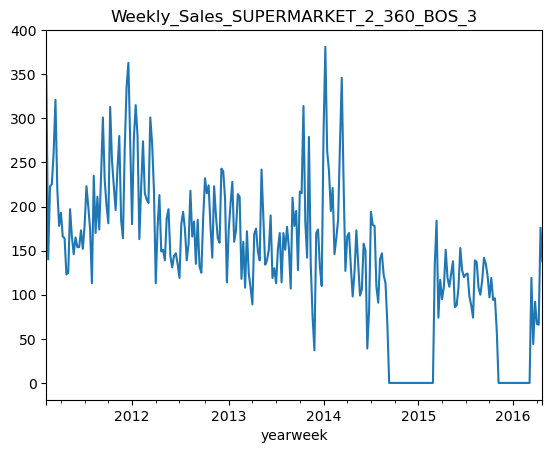

<Figure size 1200x200 with 0 Axes>

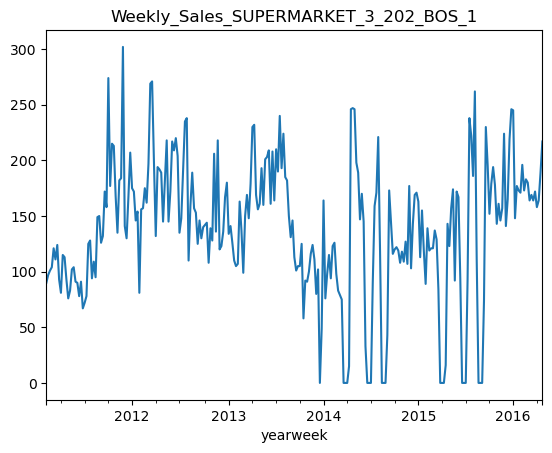

<Figure size 1200x200 with 0 Axes>

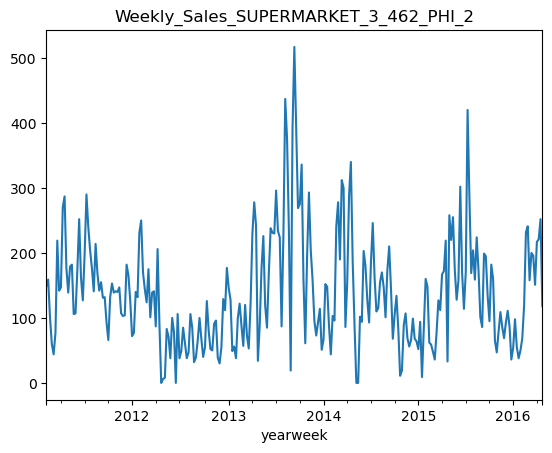

<Figure size 1200x200 with 0 Axes>

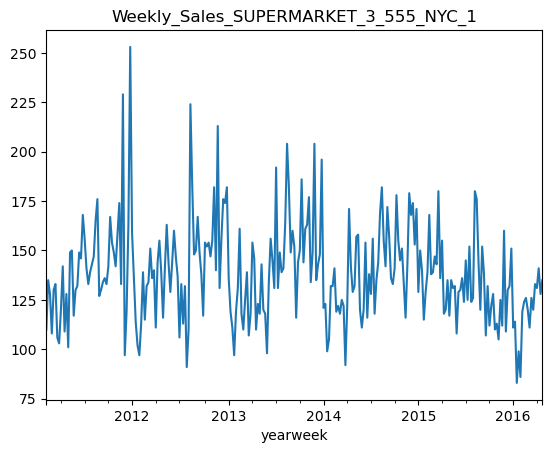

<Figure size 1200x200 with 0 Axes>

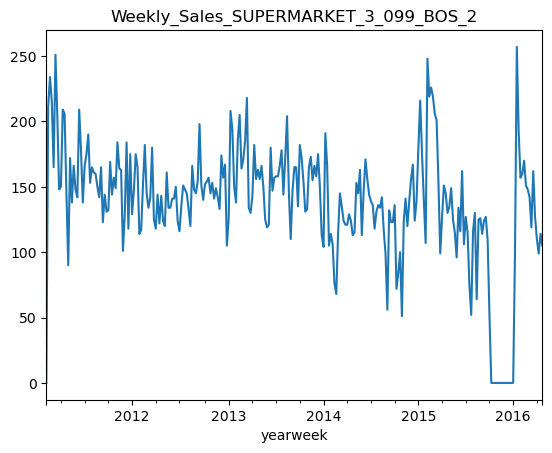

<Figure size 1200x200 with 0 Axes>

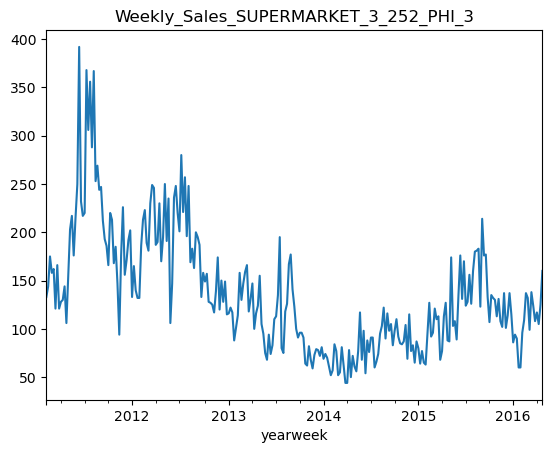

<Figure size 1200x200 with 0 Axes>

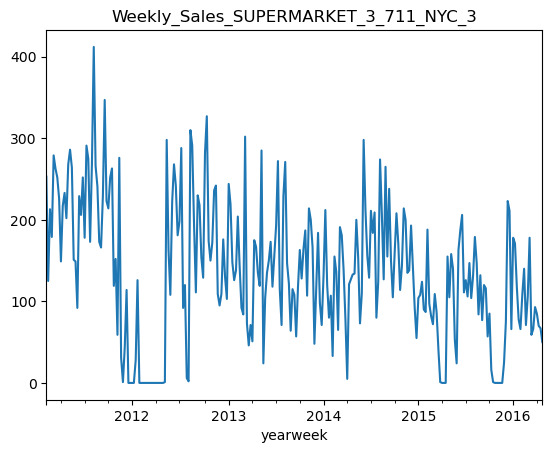

<Figure size 1200x200 with 0 Axes>

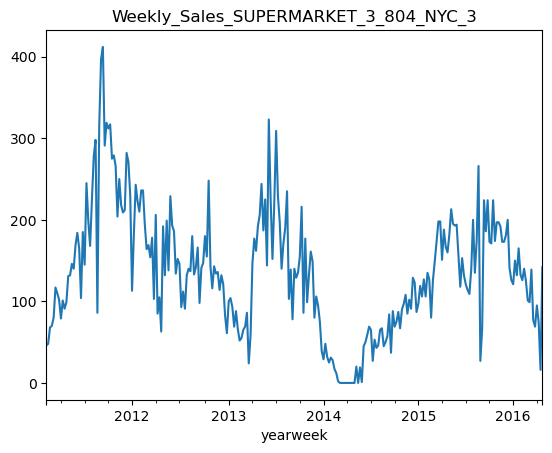

<Figure size 1200x200 with 0 Axes>

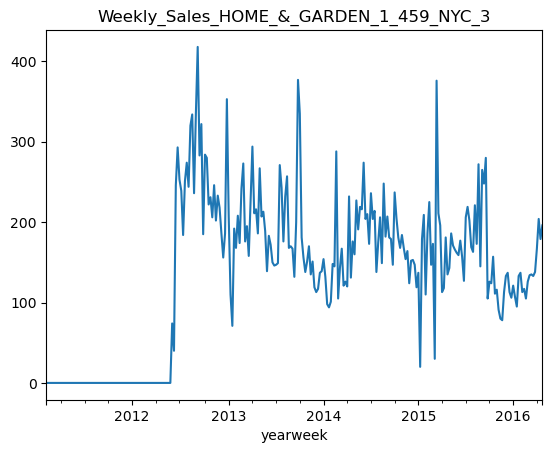

<Figure size 1200x200 with 0 Axes>

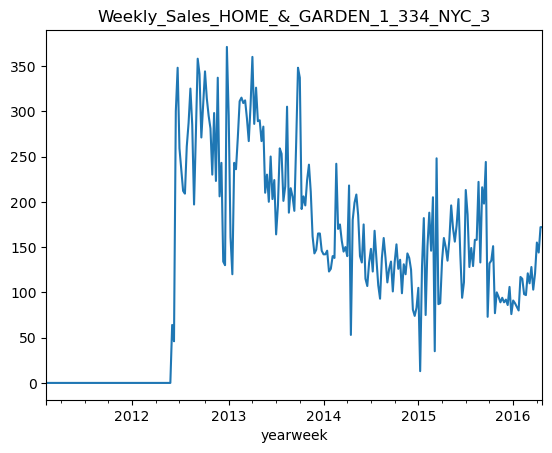

<Figure size 1200x200 with 0 Axes>

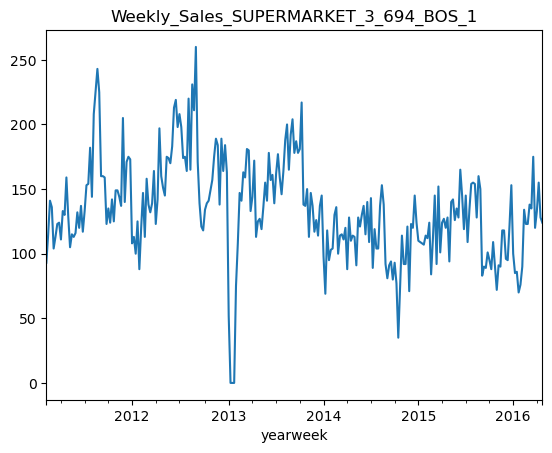

<Figure size 1200x200 with 0 Axes>

In [37]:
for i in topsales_100:
    df_topsales_100.get_group((i)).set_index("yearweek").resample("W")["weekly_sales"].sum().plot(title = f"Weekly_Sales_{i}")
    plt.figure(figsize = (12,2))
    plt.show()

In [38]:
# for i in topsales_100:
#     prophet = Prophet()
#     ts_prophet = df[df["id"] == i][["yearweek", "weekly_sales"]]
#     ts_prophet.rename(columns={'yearweek':'ds', 'weekly_sales':'y'}, inplace = True)
#     prophet.fit(ts_prophet)

#     # preparamos un df para la predicción futura
#     # prophet nos da la función auxiliar de make_future_dataframe
#     # que permite generar automáticamente los periodos necesarios para el forecast futuro
#     future_df = prophet.make_future_dataframe(periods = 4, freq = "W", include_history = True)

#     # hacemos la predicción
#     y_pred_prophet = prophet.predict(future_df)

#     prophet.plot(y_pred_prophet)

In [39]:
df.head()

yearweek                      id              item    category  \
0 2011-02-06  ACCESORIES_1_001_NYC_1  ACCESORIES_1_001  ACCESORIES   
1 2011-02-06  ACCESORIES_1_002_NYC_1  ACCESORIES_1_002  ACCESORIES   
2 2011-02-06  ACCESORIES_1_003_NYC_1  ACCESORIES_1_003  ACCESORIES   
3 2011-02-06  ACCESORIES_1_004_NYC_1  ACCESORIES_1_004  ACCESORIES   
4 2011-02-06  ACCESORIES_1_005_NYC_1  ACCESORIES_1_005  ACCESORIES   

               store store_code    region  weekly_sales  estacion  week_event  \
0  Greenwich_Village      NYC_1  New York             0  invierno           0   
1  Greenwich_Village      NYC_1  New York             0  invierno           0   
2  Greenwich_Village      NYC_1  New York             0  invierno           0   
3  Greenwich_Village      NYC_1  New York             0  invierno           0   
4  Greenwich_Village      NYC_1  New York             0  invierno           0   

   ...  San_Patricio  San_Valentin  Superbowl  Thanksgiving  Amazon_prime_day  \
0  ...             0             0          0             0                 0   
1  ...             0             0          0             0                 0   
2  ...             0             0          0             0                 0   
3  ...             0             0          0             0                 0   
4  ...             0             0          0             0                 0   

   dia_de_la_indep  dia_madre  dia_padre  sell_price  revenue  
0                0          0          0       12.74      0.0  
1                0          0          0        5.28      0.0  
2                0          0          0        3.95      0.0  
3                0          0          0        5.77      0.0  
4                0          0          0        3.96      0.0  

[5 rows x 22 columns]

In [40]:
topsales_100_predictions=pd.DataFrame()

In [41]:

for i in topsales_100:
    ts_top100 = df[df["id"] == i][["yearweek", "weekly_sales"]]
    ts_top100 = ts_top100.set_index('yearweek')
    ts_top100.indexname = None
    ts_top100.rename(columns={'weekly_sales':'y'}, inplace = True)
    hw_model = ExponentialSmoothing(
        #endog = ts_all_sales_train["y"],
        endog = ts_top100["y"],
        trend = "add", # aditivo 
        seasonal = "add", # aditivo
        seasonal_periods = 4 # ojo que debemos saber nuestros periodos. Hay que visualizar la TS y determinarlo
        )
    hw_model_fitted = hw_model.fit()
    hw_model_fittedvalues = hw_model_fitted.fittedvalues
    ts_top100_serie = ts_top100.squeeze()
    hw_model_fittedvalues = ts_top100_serie.append(hw_model_fitted.forecast(steps = 4))
    topsales_100_predictions[f"y_pred_{i}"] = hw_model_fittedvalues 
    



c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lola\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will b

In [42]:
topsales_100_predictions

y_pred_SUPERMARKET_3_090_NYC_3  y_pred_SUPERMARKET_3_586_BOS_2  \
2011-02-06                      970.000000                      460.000000   
2011-02-13                      481.000000                      531.000000   
2011-02-20                        0.000000                      590.000000   
2011-02-27                        0.000000                      579.000000   
2011-03-06                        0.000000                      568.000000   
...                                    ...                             ...   
2016-04-24                      856.000000                      497.000000   
2016-05-01                      848.972022                      514.567001   
2016-05-08                      857.417420                      528.639321   
2016-05-15                      836.976870                      559.557983   
2016-05-22                      855.138277                      508.341622   

            y_pred_SUPERMARKET_3_586_BOS_3  y_pred_SUPERMARKET_3_586_NYC_3  \
2011-02-06                      601.000000                      380.000000   
2011-02-13                      616.000000                      517.000000   
2011-02-20                      750.000000                      469.000000   
2011-02-27                      654.000000                      395.000000   
2011-03-06                      700.000000                      391.000000   
...                                    ...                             ...   
2016-04-24                      410.000000                      507.000000   
2016-05-01                      409.915254                      469.415286   
2016-05-08                      428.936707                      476.178692   
2016-05-15                      427.631556                      479.320318   
2016-05-22                      403.040354                      460.639531   

            y_pred_SUPERMARKET_3_090_NYC_1  y_pred_SUPERMARKET_3_090_PHI_3  \
2011-02-06                      616.000000                      864.000000   
2011-02-13                      323.000000                      505.000000   
2011-02-20                        0.000000                        0.000000   
2011-02-27                        0.000000                        0.000000   
2011-03-06                        0.000000                        0.000000   
...                                    ...                             ...   
2016-04-24                      409.000000                      589.000000   
2016-05-01                      378.275105                      557.336421   
2016-05-08                      409.313255                      570.550793   
2016-05-15                      419.455437                      579.956975   
2016-05-22                      395.616093                      602.373487   

            y_pred_SUPERMARKET_3_090_BOS_2  y_pred_SUPERMARKET_3_090_BOS_3  \
2011-02-06                      980.000000                      831.000000   
2011-02-13                      402.000000                      453.000000   
2011-02-20                        0.000000                        0.000000   
2011-02-27                        0.000000                        0.000000   
2011-03-06                        0.000000                        0.000000   
...                                    ...                             ...   
2016-04-24                      449.000000                      451.000000   
2016-05-01                      414.145402                      442.564156   
2016-05-08                      434.545309                      446.945526   
2016-05-15                      440.682991                      456.850691   
2016-05-22                      441.661692                      466.673253   

            y_pred_SUPERMARKET_3_252_BOS_2  y_pred_SUPERMARKET_3_586_BOS_1  \
2011-02-06                      241.000000                      294.000000   
2011-02-13                      291.000000                      315.000000   
2011-02-20                    

In [43]:
topsales_100_predictions.to_csv('predicciones.csv')